<img src="img/decisionmaking.png" width="400">

<p style="font-size:35px">ELEC-E7890 - User Research<br></p>
<p style="font-size:30px">Lecture 3 - Inference</p>

**Aurélien Nioche**

Aalto University

<div class="alert alert-block alert-success">
<h2><img src="img/logo/goal.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Learning objectives</h2>
    <br>
    <ul>
        <li> Understand what is a inferential test and a <i>p</i> value
        <li> Being able to assess the statistical significance of an experimental result
        <li> Differenciate what is a type-1 and type-2 error
        <li> Understand the conditions of application of a test
        <li> Know what are the most classical tests and when to apply them
        <li> Being able to assess the external validy of a study
    </ul>
</div>

####  Setup Python environment<a class="tocSkip"></a>

In [18]:
# Import the libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import string  # For adding letters in the figures
import scipy.special as sps  # For gamma function
from statsmodels.formula.api import ols # For regression analysis
from statsmodels.stats.anova import anova_lm # For ANOVA

%config InlineBackend.figure_format='retina' # For not burning your eyes
sns.set_context("notebook")
np.set_printoptions(threshold=8) # Don't print to much elements when printing arrays 

# Inferential statistics: What for?<a id="S1"></a>

<div class="alert alert-block alert-info"> To reply to the question:
    <lu> 
        <li>Can we generalize what we observe in our sample to the parent population?</li></lu>
    </div>

<img src="img/inferential_statistics.png" width="500">

### Example of application: Mean comparison<a class="tocSkip"></a>

Let's re-use the data from the last lecture...

#### Generate data <a class="tocSkip"></a>

In [119]:
# Seed the random number generator
np.random.seed(4)

# Set the parameters
mean_A = 150.0
mean_B = 200.0

small_sd = 10.0
large_sd = 50.0

n = 100

In [123]:
# Create the samples
xA_small_sd = np.random.normal(mean_A, scale=small_sd, size=n)
xB_small_sd = np.random.normal(mean_B, scale=small_sd, size=n)

dataset_small_sd = pd.DataFrame({"xA": xA_small_sd, "xB": xB_small_sd})
dataset_small_sd

,xA,xB
0,153.005999,192.156378
1,156.950926,203.565179
2,162.005088,218.158528
3,154.716608,203.382529
4,142.235867,199.505742
...,...,...
95,147.443956,204.662003
96,151.594475,203.956077
97,148.439267,186.530150
98,154.248767,190.588986


In [124]:
xA_large_sd = np.random.normal(mean_A, scale=large_sd, size=n)
xB_large_sd = np.random.normal(mean_B, scale=large_sd, size=n)

dataset_large_sd = pd.DataFrame({"xA": xA_large_sd, "xB": xB_large_sd})
dataset_large_sd

,xA,xB
0,213.876154,291.970040
1,156.284227,152.272958
2,71.218318,190.226083
3,228.083233,168.940630
4,230.356604,202.692846
...,...,...
95,159.129294,202.971639
96,215.969402,180.275091
97,194.959745,130.347471
98,222.037511,249.651092


#### Visualize the data <a class="tocSkip"></a>

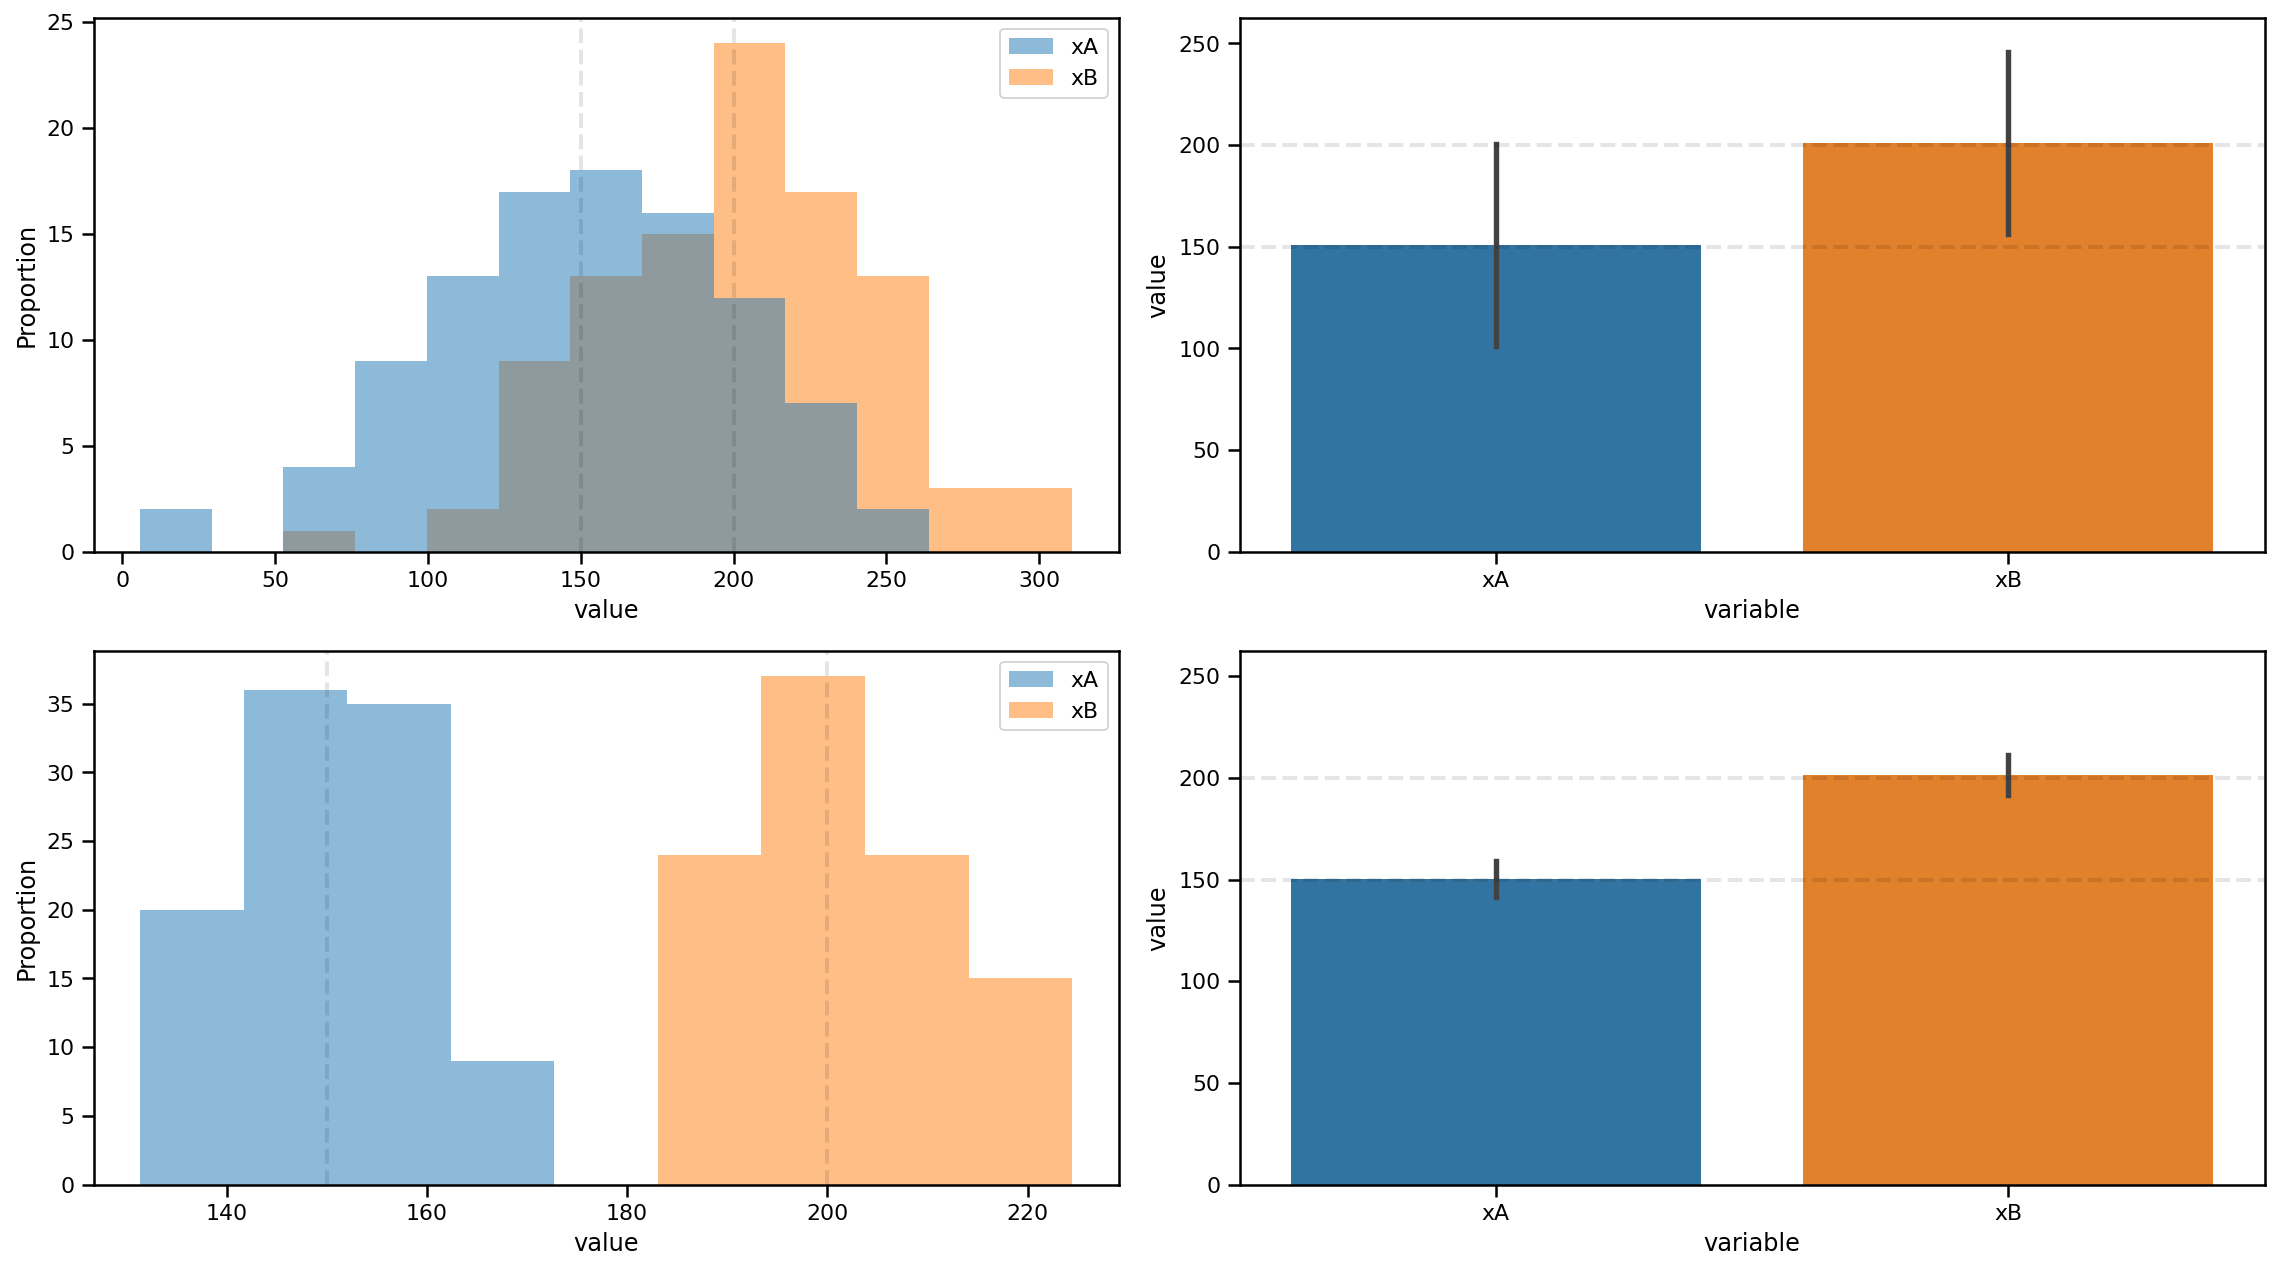

In [125]:
# Create figure and axes
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))

# For each dataset (containing each two samples)
datasets = dataset_large_sd, dataset_small_sd
for i in range(len(datasets)):
    
    # Get data
    df = datasets[i]

    # Create histograms
    ax = axes[i, 0]
    sns.histplot(data=df, ax=ax, kde=False, alpha=0.5, lw=0)
    
    # Plot the theoretical mean
    ax.axvline(mean_1, ls='--', color='black', alpha=0.1, lw=2)
    ax.axvline(mean_2, ls='--', color='black', alpha=0.1, lw=2)
    
    # Set the axis lables
    ax.set_ylabel("Proportion")
    ax.set_xlabel("value")

    # Create a barplot
    ax = axes[i, 1]
    df = df.melt()
    sns.barplot(x="variable", y="value", ax=ax, data=df, ci="sd")
    
    # Add horizontal lines representing the means
    ax.axhline(mean_1, ls='--', color='black', alpha=0.1, lw=2)
    ax.axhline(mean_2, ls='--', color='black', alpha=0.1, lw=2)
    
    # Set the y limits
    ax.set_ylim(0, max(mean_1, mean_2) + large_std * 1.25)

plt.tight_layout()
plt.show()

#### What are we looking for?<a class="tocSkip"></a>

We want to test if the population mean of $x_A$ is likely to be the same as the one of $x_b$.

<div class="alert alert-block alert-info"> Differentiate:
    <li> <b>sample</b> mean: what we observed in our (possibly small) sample</li>
    <li> <b>population</b> mean: what the mean would be if we'd measure it taking all the individuals of the population the sample belongs to.</li>
 </div>

Note that we assume here that both $x_A$ and $x_B$ are normally distributed, that is that the data come from a <a href="https://en.wikipedia.org/wiki/Normal_distribution">normal distribution</a>. More on this later...

#### Run test <a class="tocSkip"></a>

In [117]:
# Run a Student's t-test
t, p = stats.ttest_ind(dataset_small_sd.xA, dataset_small_sd.xB)

# Print the results
print(f"t={t}, p={p}")

t=-38.30501930042883, p=1.6711298544681246e-93


In [126]:
# Run a Student's t-test
t, p = stats.ttest_ind(dataset_large_sd.xA, dataset_large_sd.xB)

# Print the results
print(f"t={t}, p={p}")

t=-7.456811108424231, p=2.713690189700003e-12


Both p-values are very small, indicating that the probability of rejecting the null-hypothesis by error is small.

> It turns out that the $n$ is so large, that the difference between the two means is also statistically significant in the dataset with large variance. **Inferential statistics are a good tool to know if we could generalize what we observed** (SD/variance)!

# The p-value as the probability to reject the null hypothesis

The p-value is **the probability to reject the null hypothesis by mistake.**

So let's simulate and see how often I could be wrong...

#### Generate data <a class="tocSkip"></a>

Let's construct two samples $x_1$ and $x_2$, such that $\bar x_1 > \bar x_2$ (with $\bar x$: the observed mean for $x$), even if $\mu_{x_1} = \mu_{x_2}$ (with $\mu_x$: the theoretical/parent population mean).

In [198]:
# Seed the random number generator
np.random.seed(1234)

# Set the parameters
n = 100
mu = 100
sigma = 30

# Generate two samples
xA = np.random.normal(mu, scale=sigma, size=n)
xB = np.random.normal(mu, scale=sigma, size=n)

if np.mean(xA) > np.mean(xB):
    x1 = xA
    x2 = xB
else:
    x1 = xB
    x2 = xA

# Look at the data
df = pd.DataFrame(data={"x1": x1, "x2": x2})
df

,x1,x2
0,114.143055,108.736161
1,64.270729,116.996011
2,142.981209,115.107753
3,90.620443,108.558871
4,78.382338,114.528643
...,...,...
95,97.541588,87.053515
96,89.657020,95.165893
97,115.848644,126.674725
98,67.930336,108.651305


In [199]:
print(f"mean x1: {np.mean(df.x1)}")
print(f"mean x2: {np.mean(df.x2)}")

mean x1: 101.05336849376309
mean x2: 98.49537630605201


#### Visualize data <a class="tocSkip"></a>

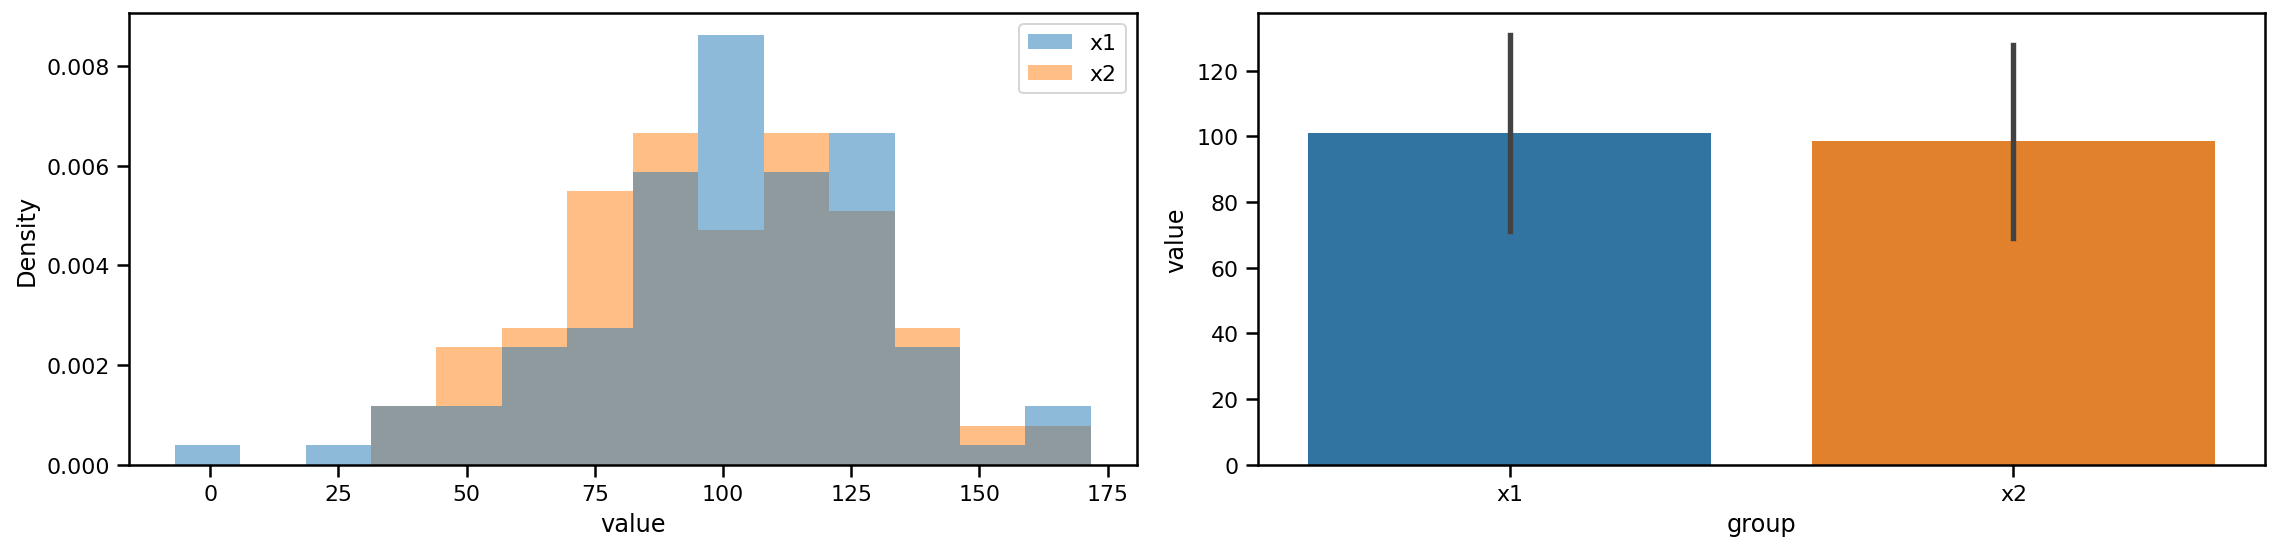

In [200]:
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4))

# Create the histograms
sns.histplot(data=df, ax=ax1, color=color, linewidth=0, alpha=0.5, 
             stat="density")  # y-axis is density instead of counts

# Put labels
ax1.set_ylabel("Density")
ax1.set_xlabel("value")

# Plot the barplot
df_melted = df.melt(var_name="group")
sns.barplot(x="group", y="value", ax=ax2, data=df_melted, ci="sd")

plt.tight_layout()
plt.show()

#### Run test <a class="tocSkip"></a>

In [201]:
# Run a Student's t-test
t, p = stats.ttest_ind(x1, x2, equal_var=True)

# Print the results
print(f"t = {t}, p = {p}")

t = 0.6077059889717964, p = 0.5440788547965428


Note that as expected, the p-value is really high (suggesting that the probability of rejecting the null-hypothesis by error is really high). Indeed, even if our samples, we observe that $\bar x_1 > \bar x_2$, the theoretical mean of both samples is the same (by construction).

#### Reproduce test result<a class="tocSkip"></a>

...by looking at which frequency I observe the inverse difference, that is $\bar x_2 > \bar x_1$ instead of $\bar x_1 > \bar x_2$, creating new datasets using as theoretical means the means observed in the samples, and as theoretical SD the SD observed in the samples.

In [202]:
# Compute the observed means for the two samples
mu1 = np.mean(x1)
mu2 = np.mean(x2)

# Compute the observed standard deviations for the two samples
sigma1 = np.std(x1)  
sigma2 = np.std(x2)

In [205]:
# Set the parameters
n_dataset = 10000

# Container for the results 
mu2_sup_mu1 = np.zeros(n_dataset)

# Create data for each dataset
for i in range(n_dataset):
    
    # Create two samples using parameters observed in the sample, and of the same size 
    new_x1 = np.random.normal(mu1, scale=sigma1, size=n)  
    new_x2 = np.random.normal(mu2, scale=sigma2, size=n)
    
    # Look if observed mean for sample 2
    # is superior for sample 1
    r = np.mean(new_x2) > np.mean(new_x1)
    
    # Store the result 
    mu2_sup_mu1[i] = r

# Compute the frequence with which 
# 'inverse' difference is observed
err_freq = np.mean(mu2_sup_mu1)

#### Visualize the results <a class="tocSkip"></a>

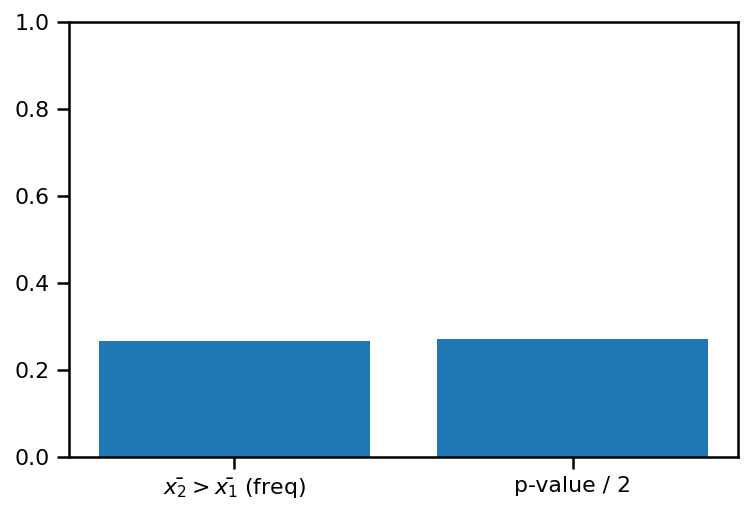

In [206]:
# Create figure and axis
fig, ax = plt.subplots()

# Define labels
labels = [r'$\bar{x_2} > \bar{x_1}$ (freq)', "p-value / 2"]

# Defines values
values = [err_freq, p/2]

# Create barplot
ax.bar(labels, values)

# Set the limit of the y-axis
ax.set_ylim(0, 1.0)

plt.show()

# The significance threshold(s)

In human/animal related studies (but not only), $p=0.05$ (5% error)

<img src="img/p005.jpg" width="600">

Note that it is before all a **convention**.

# I got it wrong: Error type I and Error type II

 || Null hypothesis is true | null hypothesis is false |
|--- | --- | ----------- |
|**Reject null hypothesis**| False positive [**Type I error**] | true negative |
|**Do not reject null hypothesis** | True positive | False negative [**Type II error**] |

<img src="img/classification.png" width="300">

Sensitivity $= \frac{TP}{TP + FN}$ ("don't miss someone positive")

Specificity = $\frac{TN}{TN + FP}$ ("don't select someone negative")

Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$ ("do good predictions overall")

Precision = $\frac{TP}{TP + FP}$ ("don't be too inclusive")

## Error type I: False positive <a id="S4.1">

<div class="alert alert-block alert-info">
    <b>False positive</b>: A result of a diagnostic test or procedure that wrongly indicates the presence of a disease or other condition.
<a href="https://www.oxfordreference.com/view/10.1093/oi/authority.20110803095809504">Oxford Reference</a>


...in our context: the test result indicates a significant difference while it was actually not the case.
</div>

Let's take an example...

#### Generate data <a class="tocSkip"></a>

In [228]:
# Seed the random number generator
np.random.seed(46)

# Set the parameters
mu = 100
sig = 10
n = 20

# Generate two samples
x1 = np.random.normal(mu, scale=sig, size=n)
x2 = np.random.normal(mu, scale=sig, size=n)

# Look at the data
df = pd.DataFrame({"x1": x1, "x2": x2})
df

,x1,x2
0,105.848758,98.648677
1,112.311957,95.216593
2,108.219003,84.050250
3,92.007716,91.310407
4,104.120532,99.672772
5,98.238434,84.725685
6,99.268280,98.754019
7,94.343336,97.380508
8,99.065348,109.953512
9,108.573011,103.175434


In [229]:
mean_x1 = np.mean(df.x1)
mean_x2 = np.mean(df.x2)

print(f"sample mean x1: {mean_x1}")
print(f"sample mean x2: {mean_x2}")

sample mean x1: 101.56887516675758
sample mean x2: 96.09697686169982


#### Visualize data <a class="tocSkip"></a>

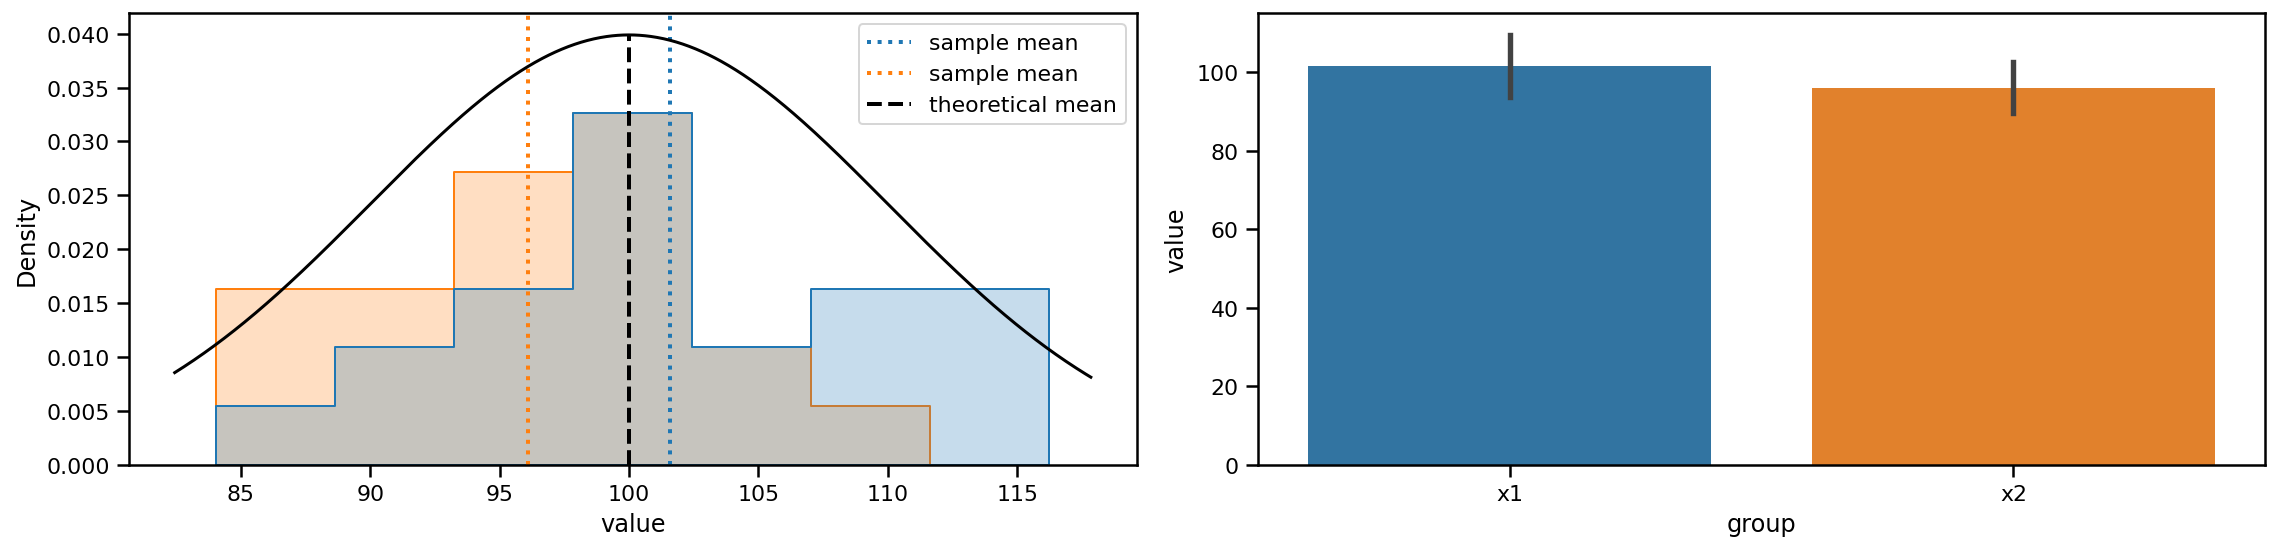

In [232]:
# Create the fig and axes
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

# Do the histogram
ax = axes[0]
sns.histplot(df, ax=ax, stat="density", element="step")

# Create the lines indicating the means
ax.axvline(mean_x1, label="sample mean", color='C0', lw=2, ls=':')
ax.axvline(mean_x2, label="sample mean", color='C1', lw=2, ls=':')

# Create the bell curve corresponding to the theoretic distribution
x_min, x_max= ax.get_xlim()
x_th = np.linspace(x_min, x_max, 1000)
y_th = stats.distributions.norm.pdf(x_th, loc=mu, scale=sig)
ax.plot(x_th, y_th, color="black")

# Create the line for the theoretical mean
ymax = stats.distributions.norm.pdf(mu, loc=mu, scale=sig)
ax.vlines(mu, ymin=0, ymax=ymax, 
          label="theoretical mean", color='black', lw=2, ls='--')

# Set the axis labels
ax.set_ylabel("Density")
ax.set_xlabel("value")

# Create the legend
ax.legend()

# Do the barplot
ax = axes[1]
df_melted = df.melt(var_name="group")
sns.barplot(x="group", y="value", ax=ax, data=df_melted, ci="sd")

plt.tight_layout()
plt.show()

#### Run test <a class="tocSkip"></a>

In [233]:
# Set the threshold 
thr = 0.05

# Run the Student's t-test
t, p = stats.ttest_ind(x1, x2, equal_var=True)

# Print the results
print(f"t={t}, p={p}, can reject={p < thr}")

t=2.324641079949218, p=0.025533350157787085, can reject=True


Result indicates that we can reject the null-hypothesis (and saying something like 'there is a difference'), while we should not do so (we know by construction that $x_1$ and $x_2$ come from the same distribution): it is a **false positive**.

## Error type II: False negative <a id="S4.2">

<div class="alert alert-block alert-info">

**False negative**: A result of a diagnostic test or procedure that wrongly indicates the absence of a disease or other condition.
    <a href="https://www.oxfordreference.com/view/10.1093/oi/authority.20110803095809486">Oxford Reference</a>

...in our context: a significant difference.
</div>

Let's take an example...

#### Generate data <a class="tocSkip"></a>

In [234]:
# Seed the random number generator
np.random.seed(0)

# Set the parameters
m1, m2 = 0, 1
sig = 0.9
n = 20

# Generate two samples
x1 = np.random.normal(m1, scale=sig, size=n)
x2 = np.random.normal(m2, scale=sig, size=n)

# Look at the data
df = pd.DataFrame({"x1": x1, "x2": x2})
df

,x1,x2
0,1.587647,-1.297691
1,0.360141,1.588257
2,0.880864,1.777993
3,2.016804,0.332051
4,1.680802,3.042779
5,-0.879550,-0.308929
6,0.855080,1.041183
7,-0.136221,0.831535
8,-0.092897,2.379501
9,0.369539,2.322423


#### Visualize data <a class="tocSkip"></a>

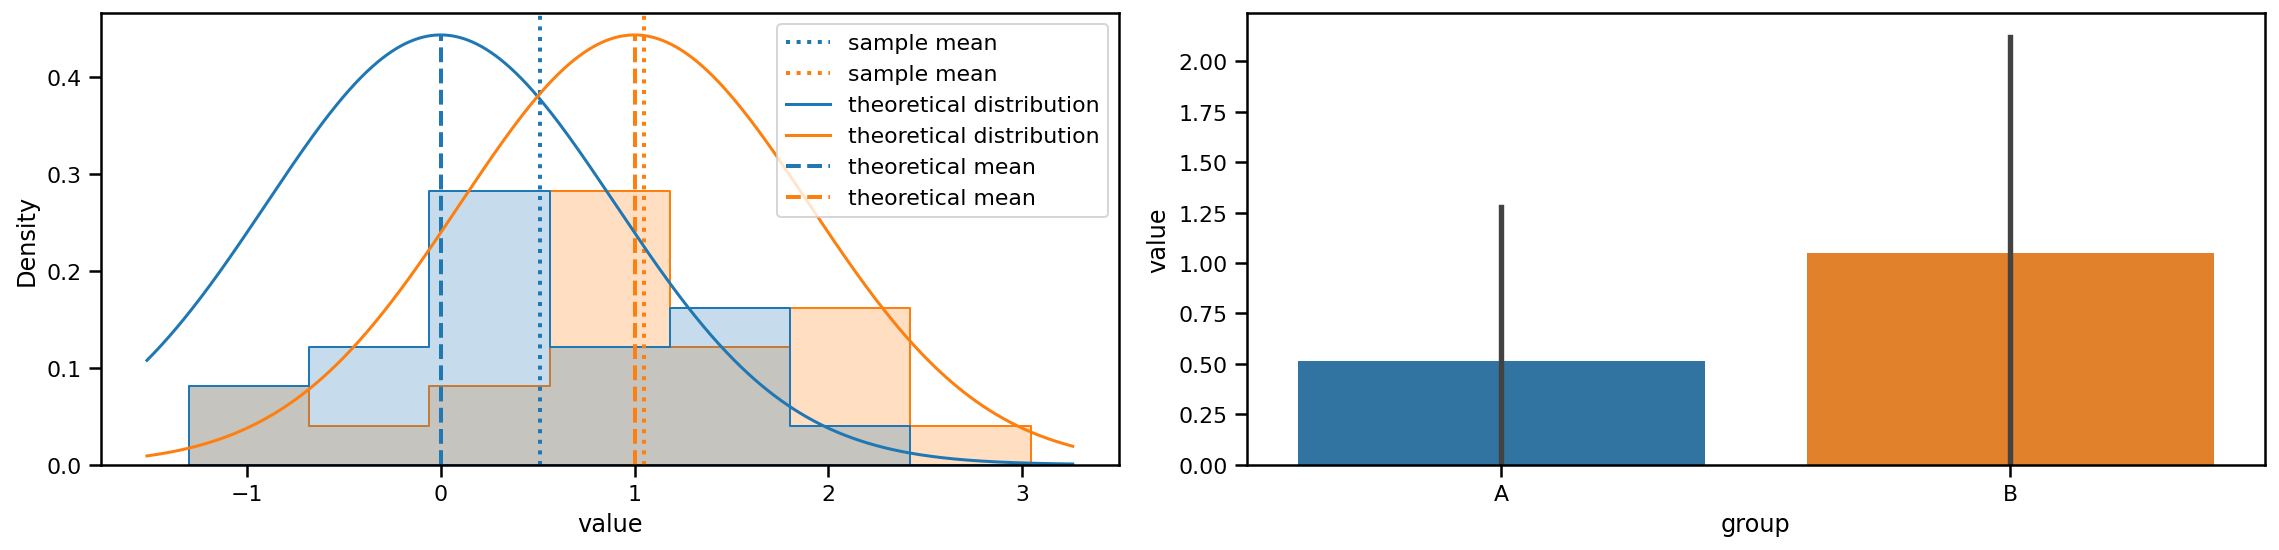

In [235]:
# Create the figure and axes
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

ax = axes[0]

# Plot the histogram
sns.histplot(df, ax=ax, stat="density", element="step")

# Plot the sample means
ax.axvline(np.mean(df.x1), label="sample mean", color='C0', lw=2, ls=':')
ax.axvline(np.mean(df.x2), label="sample mean", color='C1', lw=2, ls=':')

# Plot the bell curves
x_min, x_max= ax.get_xlim()

# Plot the theoretic distributions for the two samples
for m, color in (m1, "C0"), (m2, "C1"):
    
    # Plot the line for the mean
    ymax = stats.distributions.norm.pdf(m, loc=m, scale=sig)
    ax.vlines(m, ymin=0, ymax=ymax,transform=ax.transData,
              label="theoretical mean", color=color, lw=2, ls='--')
    
    # Plot the bell curve
    x_th = np.linspace(x_min, x_max, 1000)
    y_th = stats.distributions.norm.pdf(x_th, loc=m, scale=sig)
    ax.plot(x_th, y_th, color=color, label="theoretical distribution", ls='-')

# Create the axis labels 
ax.set_ylabel("Density")
ax.set_xlabel("value")

# Create the legend
ax.legend()

# Plot the barplot
ax = axes[1]
df = pd.DataFrame({"A": x1, "B": x2}).melt(var_name="group")
sns.barplot(x="group", y="value", ax=ax, data=df, ci="sd")

# Set the y-axis limits
ax.set_ylim(0, ax.get_ylim()[-1])

plt.tight_layout()
plt.show()

#### Run test <a class="tocSkip"></a>

In [236]:
# Set the threshold
thr = 0.05

# Run a Student's t-test
t, p = stats.ttest_ind(x1, x2, equal_var=True)

# Print the result
print(f"t={t}, p={p}, can reject={p < thr}")

t=-1.7830545865581873, p=0.08256721720461004, can reject=False


Result indicates that we can not reject the null-hypothesis (and saying something like 'there is no significant difference'), while we should do so (we know by construction that $x_1$ and $x_2$ do not come from the same distribution): it is a **false negative**.

#### To remember <a class="tocSkip"></a>

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    <br>
    Do not confound <b>samples</b> mean (standard deviation) with <b> population</b> mean (standard deviation): the discrepancy between both is the cause of the false negatives and false positives!
    </div>

# Case study: Mean comparison using Student's t-test<a id="S5"></a>

Original article: <a href="https://doi:10.1093/biomet/6.1.1">Student" William Sealy Gosset (1908). "The probable error of a mean". Biometrika. 6 (1): 1–25</a>.

<img src="img/William_Sealy_Gosset.jpg">
<center>William S. Gosset or "Student"</center>

<img src="img/magic.jpg">

Let's reveal the magic trick behind the p-value...

## Compute the t-statistic

### Formula <a class="tocSkip"></a>

The t statistic can be calculated as follows:

$$ t={\frac {{\bar {X}}_{1}-{\bar {X}}_{2}}{s_{p}{\sqrt {\frac {2}{n}}}}}$$
where $n = n_1 = n_2$ and $s_p$ is the pooled standard deviation of the two samples. 

Note that:
* The numerator of $t$ is the difference between two means
* The denominator of $t$ is the standard error of the difference between the two means.

The pooled standard deviation of the two samples $X_1$ and $X_2$, noted $s_p$, is defined as:

$$ s_{p}={\sqrt {\frac {s_{X_{1}}^{2}+s_{X_{2}}^{2}}{2}}} $$
with $s_{X_1}^2$ and $s_{X_2}^2$ are the unbiased estimators of the variances of $X_1$ and $X_2$.
 
The unbiased estimator of variance for a sample $X$ is defined as:

$${s_{X=[x_1, ..., x_n]}^{2}= {\frac {1}{n-1}}\sum _{i=1}^{n}\left(x_{i}-{\overline {X}}\right)^{2}}$$

---

Note: to have an intuition about why we divide by $n-1$ when computing the unbiased estimator of variance, you can watch <a href="https://www.khanacademy.org/math/ap-statistics/summarizing-quantitative-data-ap/more-standard-deviation/v/review-and-intuition-why-we-divide-by-n-1-for-the-unbiased-sample-variance">this short video</a> on Khan Academy.

---

Let's take an example...

In [129]:
# Set the random number generator
np.random.seed(1234)

# Set the parameters
n=20
m1, m2 = 100, 115
sig = 30

# Generate two samples
x1 = np.random.normal(m1, scale=sig, size=n)
x2 = np.random.normal(m2, scale=sig, size=n)

# Make a few prints
print("x1", x1)
print("x2", x2)

x1 [114.14305491  64.27072916 142.98120905 ... 108.67275823 139.63474576
  53.5928334 ]
x2 [108.92061026  95.32091968 120.80264129 ... 105.31615583 140.25024139
 186.72881546]


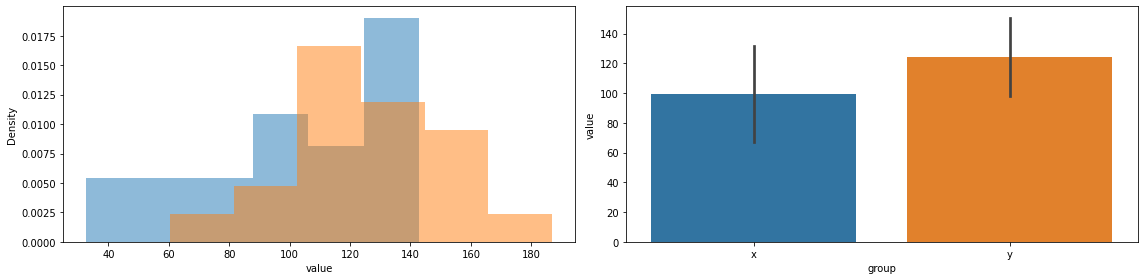

In [130]:
# Create the figure and the axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4))

# Plot the histogram
for (x, color) in (x1, "C0"), (x2, "C1"):
    sns.histplot(x, ax=ax1, color=color, linewidth=0, alpha=0.5, 
                 stat="density") # y-axis is density instead of counts

# Set the axis labels
ax1.set_ylabel("Density")
ax1.set_xlabel("value")

# Plot the barplot
df = pd.DataFrame({"x": x1, "y": x2}).melt(var_name="group")
sns.barplot(x="group", y="value", ax=ax2, data=df, ci="sd")

plt.tight_layout()
plt.show()

In [131]:
# Set the threshold
thr = 0.05

# Run a Student's t-test
t, p = stats.ttest_ind(x1, x2, equal_var=True)

# Print the result
print(f"t={t}, p={p}, can reject={p < thr}")

t=-2.591248617060576, p=0.013492277877684325, can reject=True


---

Let's compute it by hand:

[...] 

with $s_{X_1}^2$ and $s_{X_2}^2$ are the unbiased estimators of the variances of $X_1$ and $X_2$.
 
The unbiased estimator of variance for a sample $X$ is defined as:

$${s_{X=[x_1, ..., x_n]}^{2}= {\frac {1}{n-1}}\sum _{i=1}^{n}\left(x_{i}-{\overline {X}}\right)^{2}}$$
[...]

In [132]:
# Compute the unbiased estimators of the variance
var1 = np.var(x1, ddof=1)
var2 = np.var(x2, ddof=1)

# Make a few prints
print("var1", var1)
print("var2", var2)

var1 1092.6737289949485
var2 733.3891932316409


[...] 

The pooled standard deviation of the two samples $X_1$ and $X_2$, noted $s_p$, is defined as:

$${\displaystyle s_{p}={\sqrt {\frac {s_{X_{1}}^{2}+s_{X_{2}}^{2}}{2}}}.}$$
[...]

In [133]:
# Compute the pooled standard deviation of the two samples
sp = np.sqrt((var1 + var2)/2)

# Print the result
print("sp", sp)

sp 30.216410460431838


Now, we have everything we need to compute the t-test using the formula:

$$ t={\frac {{\bar {X}}_{1}-{\bar {X}}_{2}}{s_{p}{\sqrt {\frac {2}{n}}}}}$$
[...]

In [134]:
# Compute the denominator
denom = sp * np.sqrt(2 / n)

# Print the result
print("denominator", denom)

denominator 9.555267976950173


In [135]:
# Compute the numerator
mean1 = np.mean(x1)
mean2 = np.mean(x2)

num = mean1 - mean2

# Print the result
print("numerator", num)

numerator -24.76007493091535


In [136]:
# Compute the value of the t
t = num/denom

# Print the result
print("t", t)

t -2.5912486170605766


In [137]:
# Compare with the values used using Scipy
t, p = stats.ttest_ind(x1, x2, equal_var=True)
print("t", t, "p", p)

t -2.591248617060576 p 0.013492277877684325


## Compute the p-value

Student's t-distribution has the <b>probability density function</b> given by:
$$f(x) = \frac{\Gamma \left(\frac{\nu+1}{2} \right)} {\sqrt{\nu\pi}\,\Gamma \left(\frac{\nu}{2} \right)} \left(1+\frac{x^2}{\nu} \right)^{-\frac{\nu+1}{2}}$$
where $\nu$  is the number of degrees of freedom and $\Gamma (\alpha )$ is the gamma function. For all positive integers, $ \Gamma (\alpha )=(\alpha -1)!$

The <a href="https://stattrek.com/statistics/dictionary.aspx?definition=degrees-of-freedom">degrees of freedom</a> is equal $2n − 2$ where n is the number of participants in each group.

---

Computing the number of degrees of freedom is quite straightforward...

In [31]:
# Compute the number of degrees of freedom
df = 2*n - 2

# Print the result
print("degrees of freedom:", df)

degrees of freedom: 198


---

Now, let's represent the probability density function of the t-distribution, given our specific number of degrees of freedom...

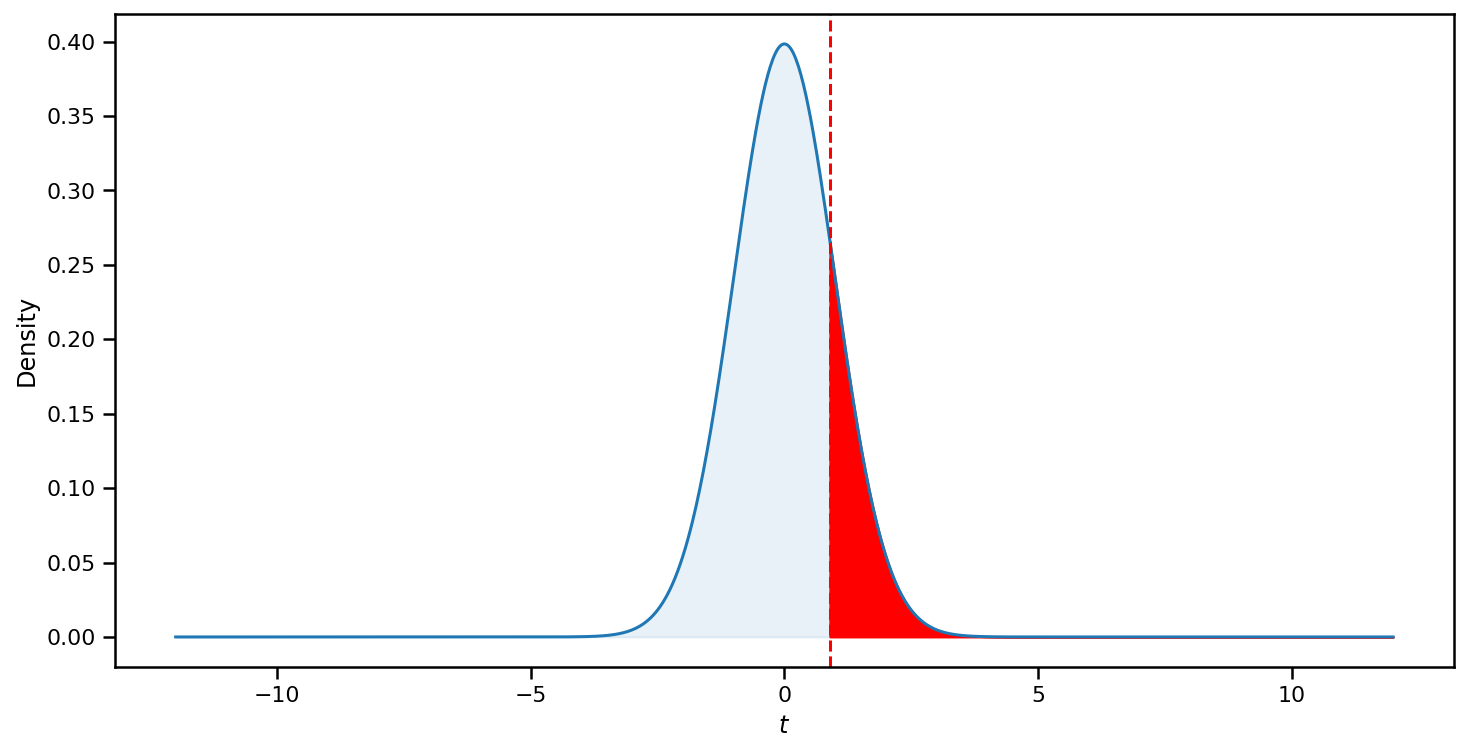

In [32]:
# Create the figure and the axis
fig, ax = plt.subplots(figsize=(12, 6))

# Shortcut for the gamma function
g = sps.gamma

# Get the absolute t-value
abs_t = np.abs(t)

# Plot the bell curve
x = np.linspace(-12, 12, 1000)
# Note that this can be shortened into 'y = stats.t.pdf(x, df=df)'
y = (g((df+1)/2) / (np.sqrt(df * np.pi)*g(df/2))) * (1+x**2/df) ** (-(df+1)/2)
ax.plot(x, y)

# Fill the area under the curve on the left of the t-value with blue
x_blue = np.linspace(-12, abs_t, 1000)
y_blue = (g((df+1)/2) / (np.sqrt(df * np.pi)*g(df/2))) * (1+x_blue**2/df) ** (-(df+1)/2)
ax.fill_between(x_blue, 0, y_blue, color="C0", alpha=0.1)

# Fill the area under the curve on the right of the t-value with red
x_red = np.linspace(abs_t, 12, 1000)
y_red = (g((df+1)/2) / (np.sqrt(df * np.pi)*g(df/2))) * (1+x_red**2/df) ** (-(df+1)/2)
ax.fill_between(x_red, 0, y_red, color="red")

# Draw the line for representing the t-value
ax.axvline(abs_t, ls='--', color="red")

# Set the axis labels
ax.set_xlabel(r"$t$")
ax.set_ylabel("Density")

plt.show()

The p-value one sided correspond to the area under the curve after the t-value.

For computing the area under the curve, we need the cumulative distribution function...

---

The <b>cumulative distribution function</b> is given by:
$$
     F(x) = \frac{1}{2} + x \Gamma \left( \frac{\nu+1}{2} \right)  \times
     \frac{\,_2F_1 \left ( \frac{1}{2},\frac{\nu+1}{2};\frac{3}{2};
           -\frac{x^2}{\nu} \right)}
     {\sqrt{\pi\nu}\,\Gamma \left(\frac{\nu}{2}\right)}$$
where $_2F_1$ is the hypergeometric function

---

Let's represent the cumulative distribution function...

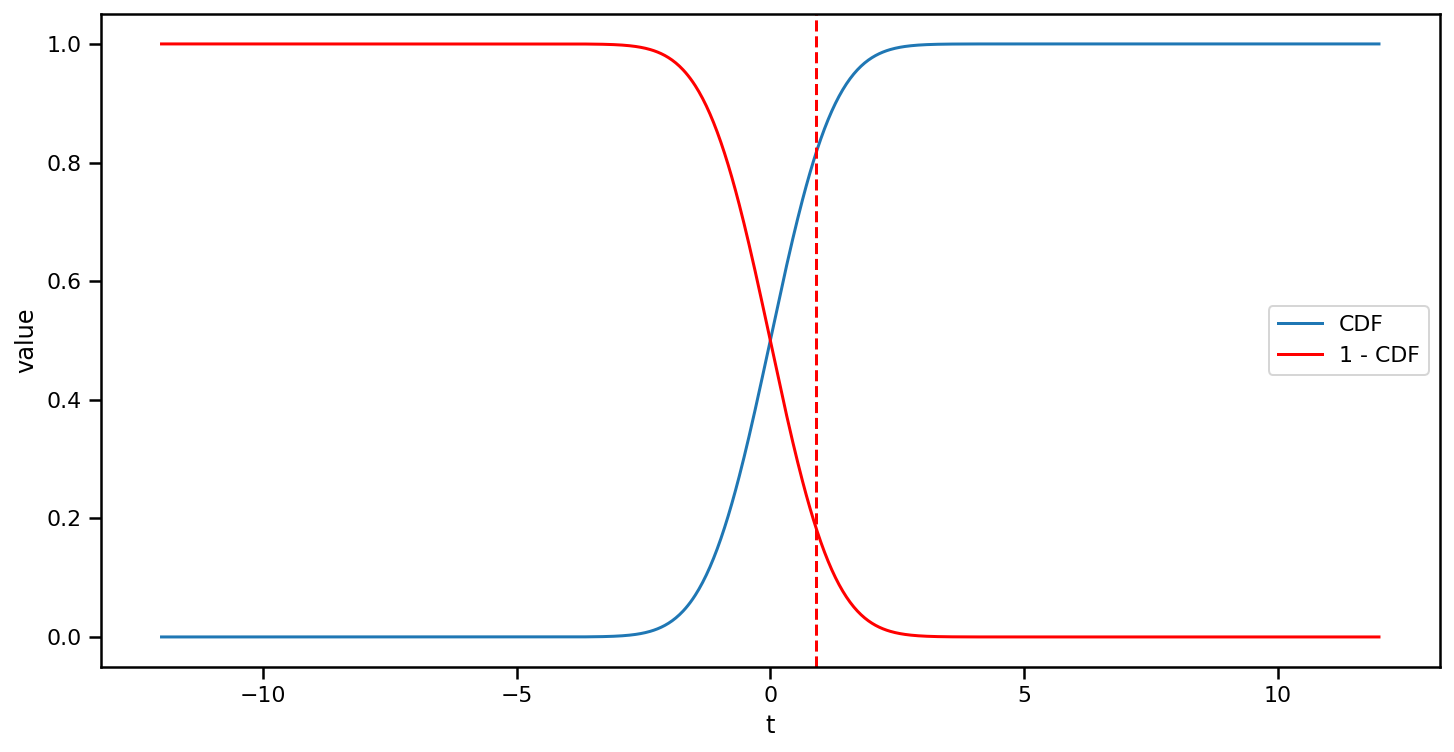

In [33]:
# Create the figure and the axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the cumulative distribution functiion
x = np.linspace(-12, 12, 1000)
y1 = stats.t.cdf(x, df)
ax.plot(x, y1, label="CDF", color="C0")

# Plot the survival function (1 - CDF)
ax.plot(x, 1 - y1, label="1 - CDF", color="red")

# Plot the line representing the t-value
ax.axvline(abs_t, ls='--', color="red")

# Set the axis labels
ax.set_xlabel("t")
ax.set_ylabel("value")

# Create the legend
ax.legend()

plt.show()

---

Let's know compute p-value (note that without multiplying by 2, it will be the one-sided p-value: see the <a href="#S5.3">next subsection</a>)

In [34]:
# Compute the p-value
p = (1 - stats.distributions.t.cdf(abs_t, df)) * 2

# Print the result
print("p", p)

p 0.37091913830039935


In [35]:
# Compute the p-value using Scipy and compare...
t, p = stats.ttest_ind(x1, x2)
print("t", t, "p", p)

t -1.9686834528275583 p 0.05038483660239001


---

<i>Note: For further explanation on the computation of the p-value, you can refer to: <a href="https://doi.org/10.1038/nmeth.2698">Krzywinski, M., Altman, N. Significance, P values and t-tests. Nat Methods 10, 1041–1042 (2013).</a></i>

## One-sided vs two-sided

We talk about 'two-sided' because you take the value under the curve on both sides of the probability function.

Let's represent that graphically...

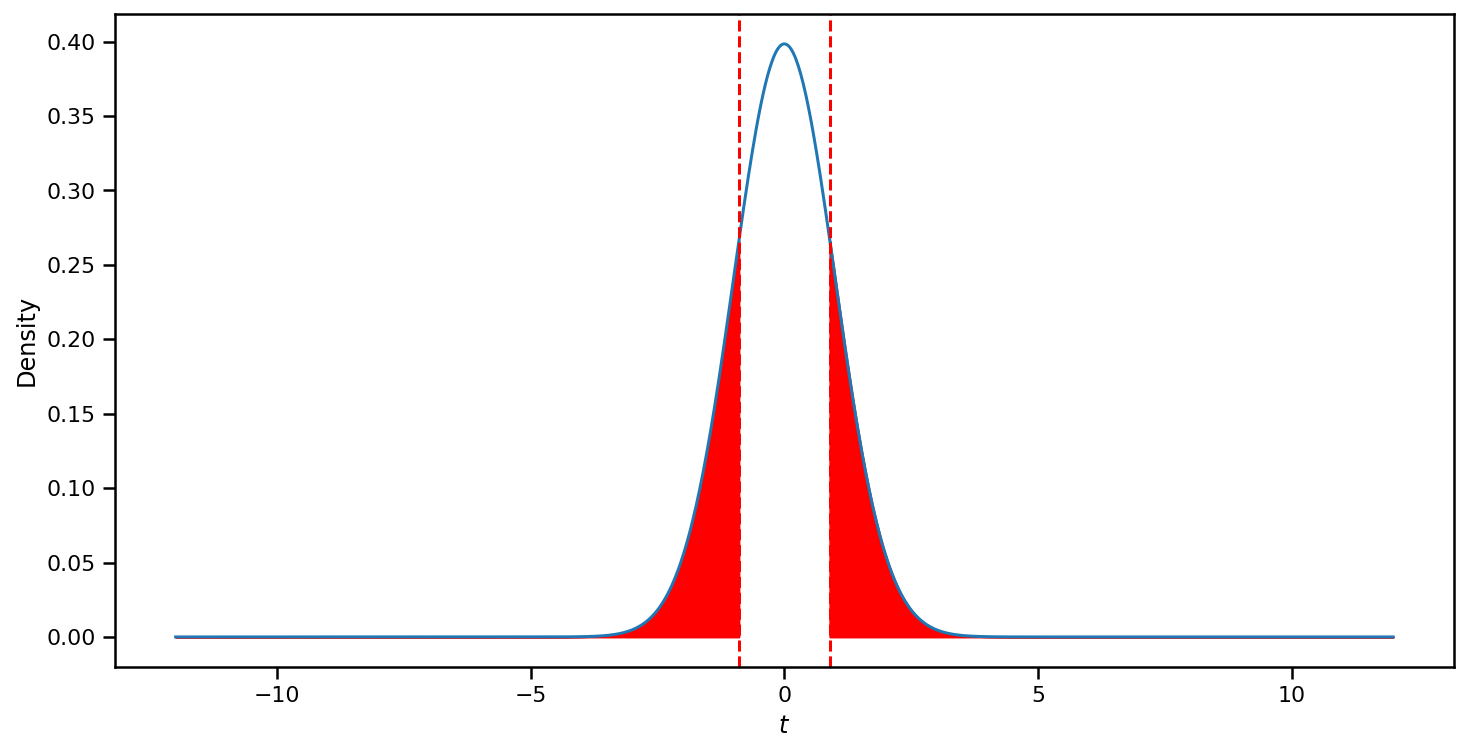

In [36]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Define x-limits 
min_x, max_x = -12, 12

# Plot the bell curve
x = np.linspace(min_x, max_x, 1000)
y = stats.t.pdf(x, df=df)  # Now, using the shortcut provided by Scipy
ax.plot(x, y)

# Set the axis labels
ax.set_xlabel(r"$t$")
ax.set_ylabel("Density")

# Fill the area under the curve
for t_ in (abs_t, -abs_t):
    if t_ > 0:
        x = np.linspace(t_, max_x, 1000)
    else:
        x = np.linspace(min_x, t_, 1000)
    y_f = stats.t.pdf(x, df=df)
    ax.fill_between(x, 0, y_f, color="red")
    
    # Draw a line corresponding to the t-value
    ax.axvline(t_, ls='--', color="red")

plt.show()

---

<i>Note: **Two-sided** is **more conservative** than one sided</i> (you should by default use a two-sided, except if you have strong reason to not do so)

## The number of subjects matters

Let's the see how the p-value for a given t-value change depending on the number of subjects...

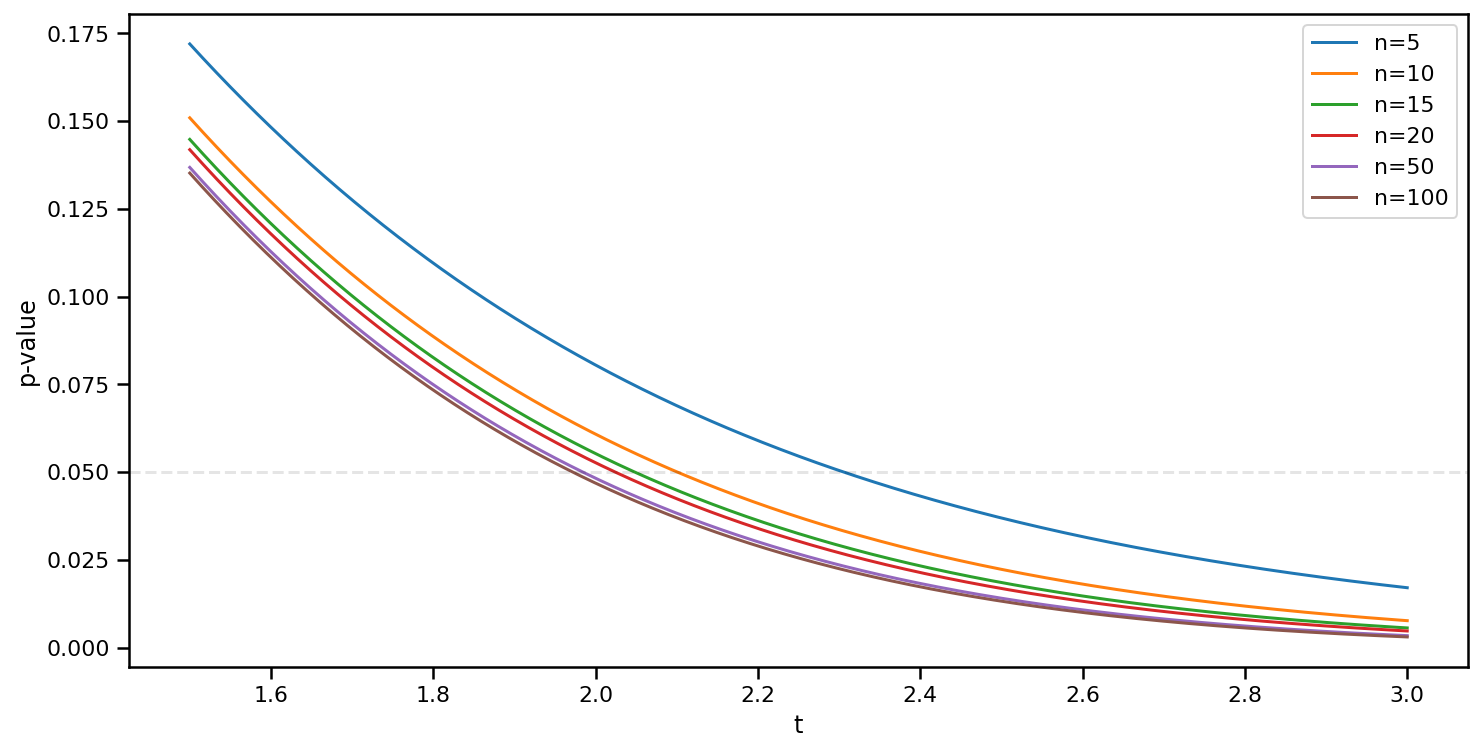

In [37]:
# Set the sample size to use
ns = [5, 10, 15, 20, 50, 100]

# Set the t-values to use
x = np.linspace(1.5, 3, 1000)

# Create the figure
fig, ax = plt.subplots(figsize=(12, 6))

# For each n...
for n in ns:
    # Compute the number of degrees of freedom
    df = 2*n - 2
    
    # Compute the CDF
    y = (1 - stats.distributions.t.cdf(x, df)) * 2
    
    # Plot the result
    ax.plot(x, y, label=f"n={n}")
    
# Set the axis labels
ax.set_xlabel("t")
ax.set_ylabel("p-value")

# Create a line for the magic threshold
ax.axhline(0.05, ls='--', color="black", alpha=0.1)

# Create the legend
ax.legend()

plt.show()

The more you will increase your $n$, the more you will increase the probability to have significant results

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    <br>
    Use a <b>number large enough of subjects</b> to avoid <b>false negatives</b>.
    </div>

# The condition of application of a stastical test: Which test can I use?

What we can see in the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html">doc</a> for the t-test's implementation from Scipy:

<img src="img/doc_t_test.png" width="600">

A Student t-test assumes that:

* <b> Equal size of sample </b>

* <b> Normal distribution</b>:  The population from which samples are drawn should be normally distributed.

* <b>Homogeneity of variance</b>: Homogeneity means that the variance among the groups should be approximately equal.

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    <br>
    A statistical test have <b>conditions</b> of application relative to the <b>shape of the distributions</b> you wish to compare
    </div>

Let's see with two samples how to test if they meet the requirements for comparing them with a Student's t-test:

In [38]:
# Seed the random number generator
np.random.seed(1285)

# Set the parameters
n = 100
mu1 = 10
mu2 = 20
sig = 10

# Generate the sample
x1 = np.random.normal(mu1, scale=sig, size=n)
x2 = np.random.normal(mu2, scale=sig, size=n)

Testing the size of sample is pretty straightforward...

In [39]:
# Test the equality of sample sizes
is_equal = len(x1) == len(x2)

# Print the result
print("is equal", is_equal)

is equal True


Let's test the normality of the distribution using a <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html">D’Agostino and Pearson’s</a> test. The <b>null hypothesis</b> is that the <b>data are normally distributed</b>.

In [40]:
# Run the  D’Agostino and Pearson’s test for sample x1
k, p = stats.normaltest(x1)

# Print the result
print(f"k={k}, p={p}")

k=1.5798844659411548, p=0.4538710133052598


In [41]:
# Run the  D’Agostino and Pearson’s test for sample x2
k, p = stats.normaltest(x2)

# Print the result
print(f"k={k}, p={p}")

k=0.9889358066077525, p=0.6098953442704012


Let's test the normality of the distribution using a <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html">Levene</a> test. The <b>null hypothesis</b> is that the <b>all samples are from populations with equal variances</b>.

In [42]:
# Run the Levene test
stat, p = stats.levene(x1, x2)

# Print the result
print(f"k={k}, p={p}")

k=0.9889358066077525, p=0.7942487504762309


## The number of subjects is not the same and/or variances are unequal: Welch's t-test

...but the <b>distribution</b> is still (expected to be) <b>normal</b>

In [43]:
# Seed the random number generator
np.random.seed(4)

# Set the parameters
m1, m2 = 100, 150
sd1, sd2 = 50, 10
n = 100

# Generate two samples
x1 = np.random.normal(m1, scale=sd1, size=n)
x2 = np.random.normal(m2, scale=sd2, size=n)

# Make a few prints
print("x1", x1)
print("x2", x2)

x1 [102.52808536 124.99756666  50.20455344 ...  91.42676952  52.78157003
 114.04323377]
x2 [157.38247111 156.50753231 156.1474063  ... 158.76742482 145.17121314
 140.14581539]


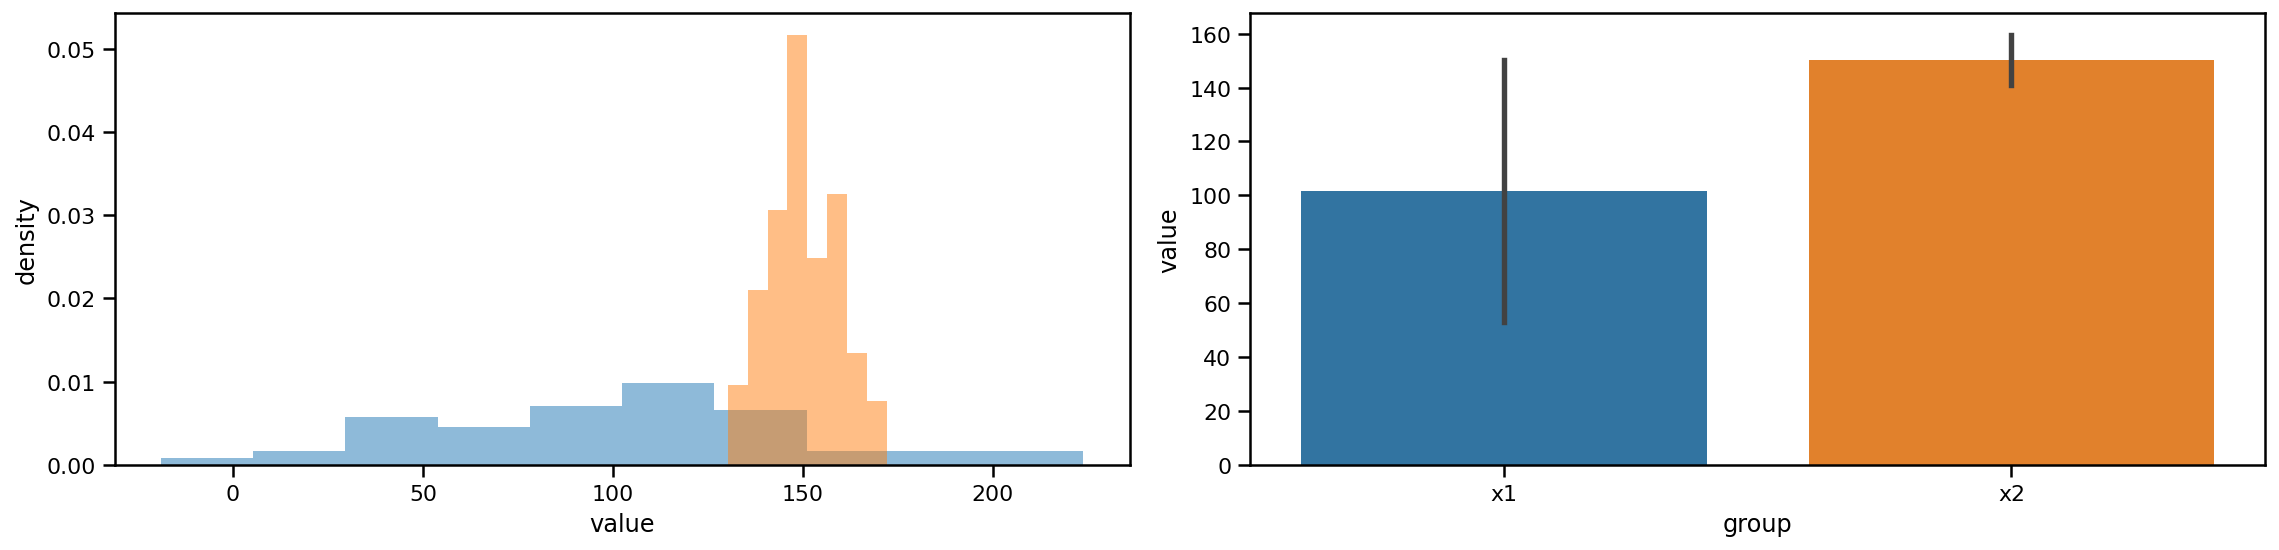

In [44]:
# Create figure and axes
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

# Plot the histogram
ax = axes[0]
sns.histplot(x1, ax=ax, color="C0", linewidth=0, alpha=0.5, stat="density")
sns.histplot(x2, ax=ax, color="C1", linewidth=0, alpha=0.5, stat="density")

# Set the axis labels
ax.set_ylabel("density")
ax.set_xlabel("value")

# Plot the barplot
ax = axes[1]
df = pd.DataFrame({"x1": x1, "x2": x2}).melt(var_name="group")
sns.barplot(x="group", y="value", ax=ax, data=df, ci="sd")

plt.tight_layout()
plt.show()

The Welch's t-test can be computed this way:

$${\displaystyle t={\frac {{\bar {X}}_{1}-{\bar {X}}_{2}}{s_{\bar {\Delta }}}}}$$
where

$${\displaystyle s_{\bar {\Delta }}={\sqrt {{\frac {s_{1}^{2}}{n_{1}}}+{\frac {s_{2}^{2}}{n_{2}}}}}.}$$

In [45]:
# Compute a Welch's t-test
# Note that the 'equal-var=False' that will force the use of a Welch's t-test 
# (instead of a Student t-test)
t, p = stats.ttest_ind(x1, x2, equal_var=False)

# Print the result
print(f"t={t}, p={p}")

t=-9.732916761113751, p=2.1823383644149874e-16


## The distribution is not (does not seem) normal: Rank dependant tests

...also called '<b>non-parametric</b>' tests.

Let's take an example...

---

Let's now consider data following a Gamma distribution, that is such that:
$$ D_G \sim \mathrm{Gamma} (\alpha ,\beta )$$
the probability density function of the Gamma distribution being :
$${\begin{aligned}f(x;\alpha ,\beta )&={\frac {\beta ^{\alpha }x^{\alpha -1}e^{-\beta x}}{\Gamma (\alpha )}}\quad {\text{ for }}x>0\quad \alpha ,\beta >0,\\[6pt]\end{aligned}}$$
where $\Gamma (\alpha )$ is the gamma function. For all positive integers, $ \Gamma (\alpha )=(\alpha -1)!$

In [46]:
# Seed the random number generator
np.random.seed(124)

# Set the parameters
# From the doc of 'np.random.gamma': Samples are drawn from a Gamma distribution with specified parameters, 
# shape (sometimes designated “k”) and scale (sometimes designated “theta”), 
# where both parameters are > 0.
# knowing that theta = 1/beta
k1, t1 = 1, 10
k2, t2 = 1.3, 14
n = 25

# Generate two samples
x1 = np.random.gamma(k1, scale=t1, size=n)
x2 = np.random.gamma(k2, scale=t2, size=n)

# Make a few prints
print("x1", x1)
print("x2", x2)

x1 [ 1.12122108 13.68342406  8.49364914 ...  8.10844989  5.19171155
  1.52866687]
x2 [29.33705625 10.55513547  9.03522155 ... 30.88223766 70.36511674
 13.5331025 ]


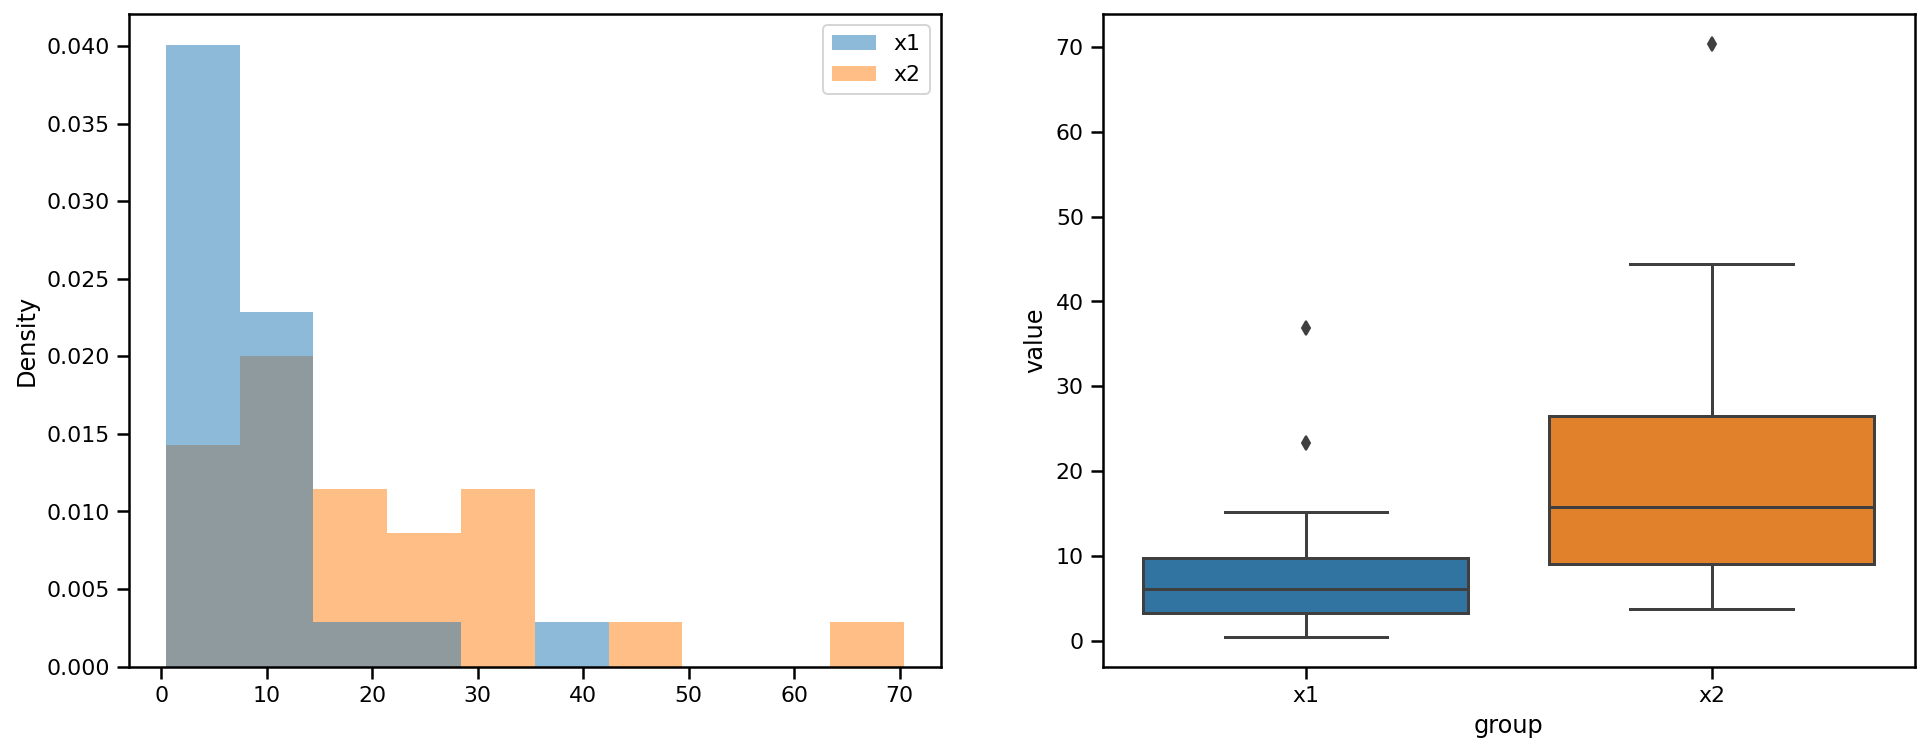

In [47]:
# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

# Plot the histogram
sns.histplot(ax=ax1, data=pd.DataFrame({"x1": x1, "x2": x2}),
             stat="density",  linewidth=0, alpha=0.5)

# Plot the boxplot
df = pd.DataFrame({"x1": x1, "x2": x2}).melt(var_name="group")
sns.boxplot(x="group", y="value", ax=ax2, data=df)

plt.show()

### Compute a Mann–Whitney U

Original article: <a href="doi:10.1214/aoms/1177730491">Mann, Henry B.; Whitney, Donald R. (1947). "On a Test of Whether one of Two Random Variables is Stochastically Larger than the Other". Annals of Mathematical Statistics. 18 (1): 50–60.</a> 

In [48]:
# Compute the Mann-Whitney U
# Note: the default option is deprecated
# Remember to use the argument "alternative='two-sided'"
u, p = stats.mannwhitneyu(x1, x2, alternative='two-sided')

# Print the results
print(f"u = {u}, p={p}")

u = 131.0, p=0.00044488884040892583


---

How does it work?

1. Assign numeric ranks to all the observations (put the observations from both groups to one set), beginning with 1 for the smallest value. Where there are groups of tied values, assign a rank equal to the midpoint of unadjusted rankings. 

Ex: 
* the ranks of (3, 5, 6, 15, 25) are (1, 2, 3, 4, 5)
* the ranks of (3, 5, 5, 5, 5, 8) are (1, 3.5, 3.5, 3.5, 3.5, 6) <i>[note the unadjusted rank would be (1, 2, 3, 4, 5, 6))]</i>.


In [49]:
# Compute the n
n1 = len(x1)
n2 = len(x2)

# Rank the values
ranked = stats.rankdata(np.concatenate((x1, x2)))

# Print the result
print("ranked values", ranked)

ranked values [ 2. 32. 22. ... 45. 50. 31.]


2. add up the ranks for the observations which came from sample 1. The sum of ranks in sample 2 is now determinate, since the sum of all the ranks equals $N(N + 1)/2$ where $N$ is the total number of observations.

$U$ is then given by:

$$U_{1}=R_{1}-{n_{1}(n_{1}+1) \over 2}\,\!$$
where n1 is the sample size for sample 1, and R1 is the sum of the ranks in sample 1.

$$U_{2}=R_{2}-{n_{2}(n_{2}+1) \over 2}\,\!$$

In [50]:
# Get the ranks for the sample x1
rank_x1 = ranked[0:n1]

# Compute U for x1
u1 = n1 * n2 + (n1 * (n1 + 1)) / 2.0 - np.sum(rank_x1, axis=0)

# The remainder is U for x2
u2 = n1 * n2 - u1

# Print the result
print(f"u1 = {u1}; u2 = {u2}")

u1 = 494.0; u2 = 131.0


In [51]:
# Compare with what is obtained using Scipy...
u, p = stats.mannwhitneyu(x1, x2, alternative='two-sided')
print(f"u = {u}, p={p}")

u = 131.0, p=0.00044488884040892583


### Compute the p-value of a Mann-Whitney U

For large samples (n>20), U is approximately normally distributed, with 

$$\mu = \frac {n_{1}n_{2}}{2}$$

$$\sigma^2 = \sqrt {n_1 n_2 (n_1+n_2+1) \over 12}$$
if there is a tie, a correction is necessary:

$$\sigma^2_{\text{corr}}={\sqrt {{n_{1}n_{2} \over 12}\left((n+1)-\sum _{i=1}^{k}{{t_{i}}^{3}-t_{i} \over n(n-1)}\right)}}\,$$

where $n = n_1 + n_2$, $t_i$ is the number of subjects sharing rank $i$, and $k$ is the number of (distinct) ranks.

In [52]:
# Compute the mean of the U distribution
mean_rank = n1*n2/2.0

# Print the result
print("mean_rank", mean_rank)

mean_rank 312.5


In [53]:
# Compute the sd of the U distribution
# Note: we assume that there is not tie here
sd = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12.0) 

# Print the result
print("sd", sd)

sd 51.53882032022076


In [54]:
# Take the max of U1 and U2
u = max(u1, u2)

# Compute the p-value
p = (1 - stats.norm.cdf(u, loc=mean_rank, scale=sd)) * 2

# Print the result
print("p", p)

p 0.0004289228995439931


In [55]:
# Alternative: compute Z-score first
z = (u - mean_rank) / sd

# Compute the p-value using the Z-score
p = (1 - stats.norm.cdf(z)) * 2
print("p", p)

p 0.0004289228995439931


In [56]:
# Compare with what is obtained using Scipy...
u, p = stats.mannwhitneyu(x1, x2, alternative='two-sided')
print(f"u = {u}, p={p}")

u = 131.0, p=0.00044488884040892583


In [57]:
# The small difference disappears with 'use_continuity=False' argument
# Indeed, by default, a correction is made assuming data 
# are on a continuous scale
u, p = stats.mannwhitneyu(x1, x2, use_continuity=False, 
                          alternative='two-sided')

# Print the result
print(f"u = {u}, p={p}")

u = 131.0, p=0.00042892289954401424


---

Don't forget to read the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html">doc</a> for the conditions of application!

<img src="img/doc_mw.png" width="600">

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    <br>
    A statistical test have <b>conditions</b> of application relative to the <b>shape of the distributions</b> you wish to compare
    </div>

## I want to compare the effect of two factors: ANOVA

or <b>ANalysis Of VAriance</b> is probably what you're looking for...

Let's see an example...

---

In [59]:
# Import the data
df = pd.read_csv("data/stcp-Rdataset-Diet.csv")

# Look at the top of the file
df

,Person,gender,Age,Height,pre.weight,Diet,weight6weeks
0,25,,41,171,60,2,60.0
1,26,,32,174,103,2,103.0
2,1,0,22,159,58,1,54.2
3,2,0,46,192,60,1,54.0
4,3,0,55,170,64,1,63.3
...,...,...,...,...,...,...,...
73,74,1,35,183,83,3,80.2
74,75,1,49,177,84,3,79.9
75,76,1,28,164,85,3,79.7
76,77,1,40,167,87,3,77.8


Data from <a href="https://www.sheffield.ac.uk/polopoly_fs/1.570199!/file/stcp-Rdataset-Diet.csv">https://www.sheffield.ac.uk/polopoly_fs/1.570199!/file/stcp-Rdataset-Diet.csv</a>

In [60]:
# Print the counts
print(df.count())

Person          78
gender          78
Age             78
Height          78
pre.weight      78
Diet            78
weight6weeks    78
dtype: int64


In [61]:
# Create a new column with the loss of weight
df["Loss"] = df["pre.weight"] - df["weight6weeks"]
print(df.head())

   Person gender  Age  Height  pre.weight  Diet  weight6weeks  Loss
0      25          41     171          60     2          60.0   0.0
1      26          32     174         103     2         103.0   0.0
2       1      0   22     159          58     1          54.2   3.8
3       2      0   46     192          60     1          54.0   6.0
4       3      0   55     170          64     1          63.3   0.7


In [62]:
# See the different values for the 'gender' column
print(df["gender"].unique())

[' ' '0' '1']


In [63]:
# Remove the lines when the data is missing
df = df[df["gender"] != ' ']

# Print the new count
print(df.count())

Person          76
gender          76
Age             76
Height          76
pre.weight      76
Diet            76
weight6weeks    76
Loss            76
dtype: int64


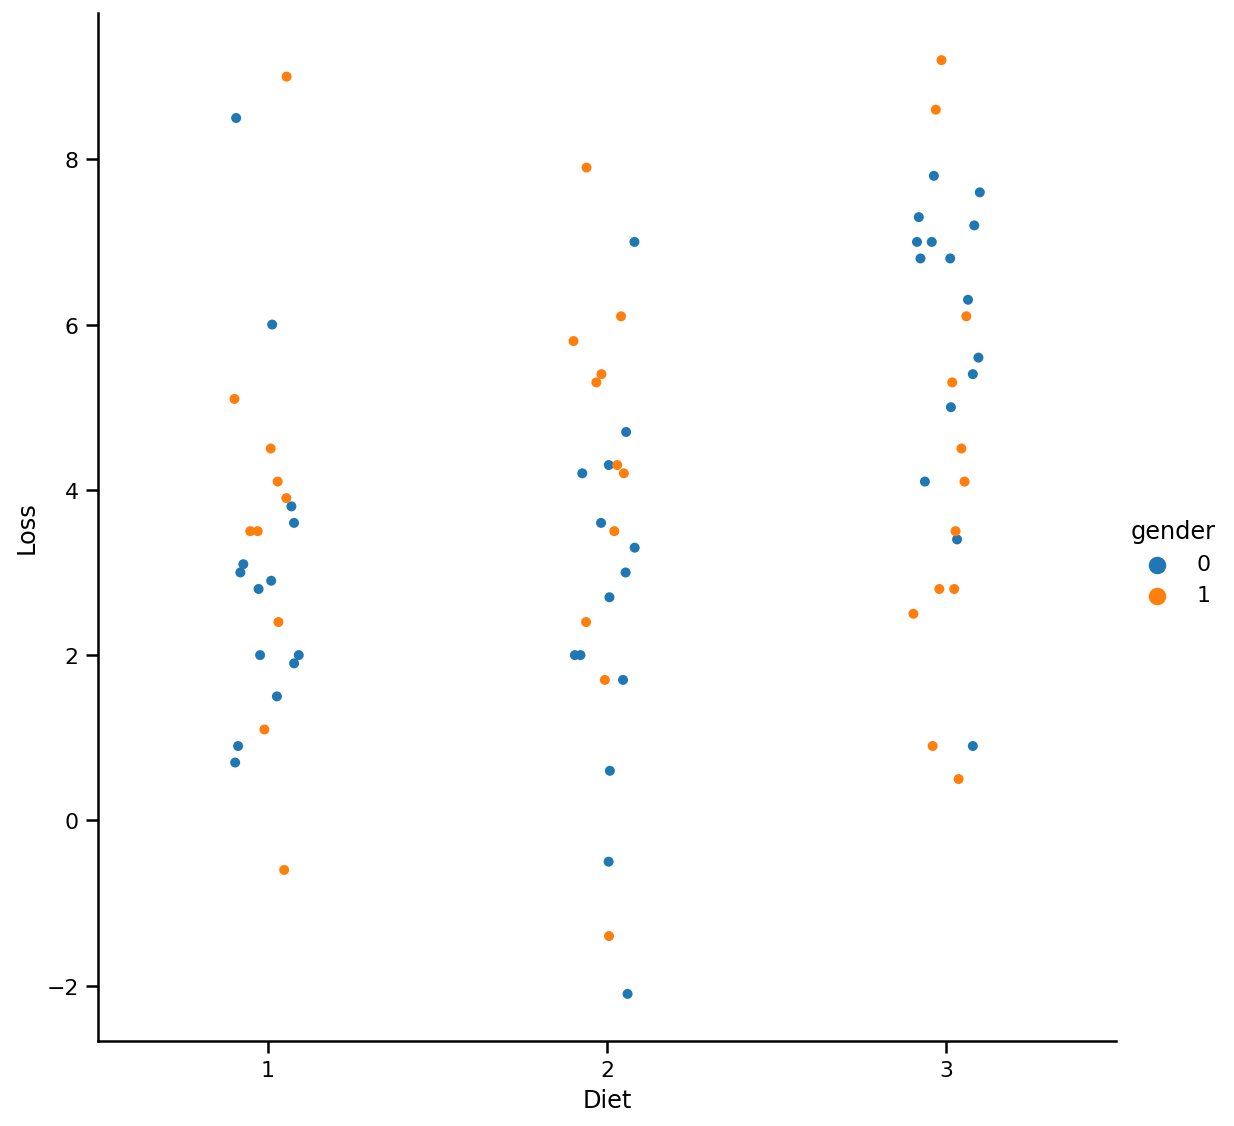

In [64]:
# Represent the raw data
g = sns.catplot(x="Diet", y="Loss", hue="gender",
                data=df, height=8)
plt.show()

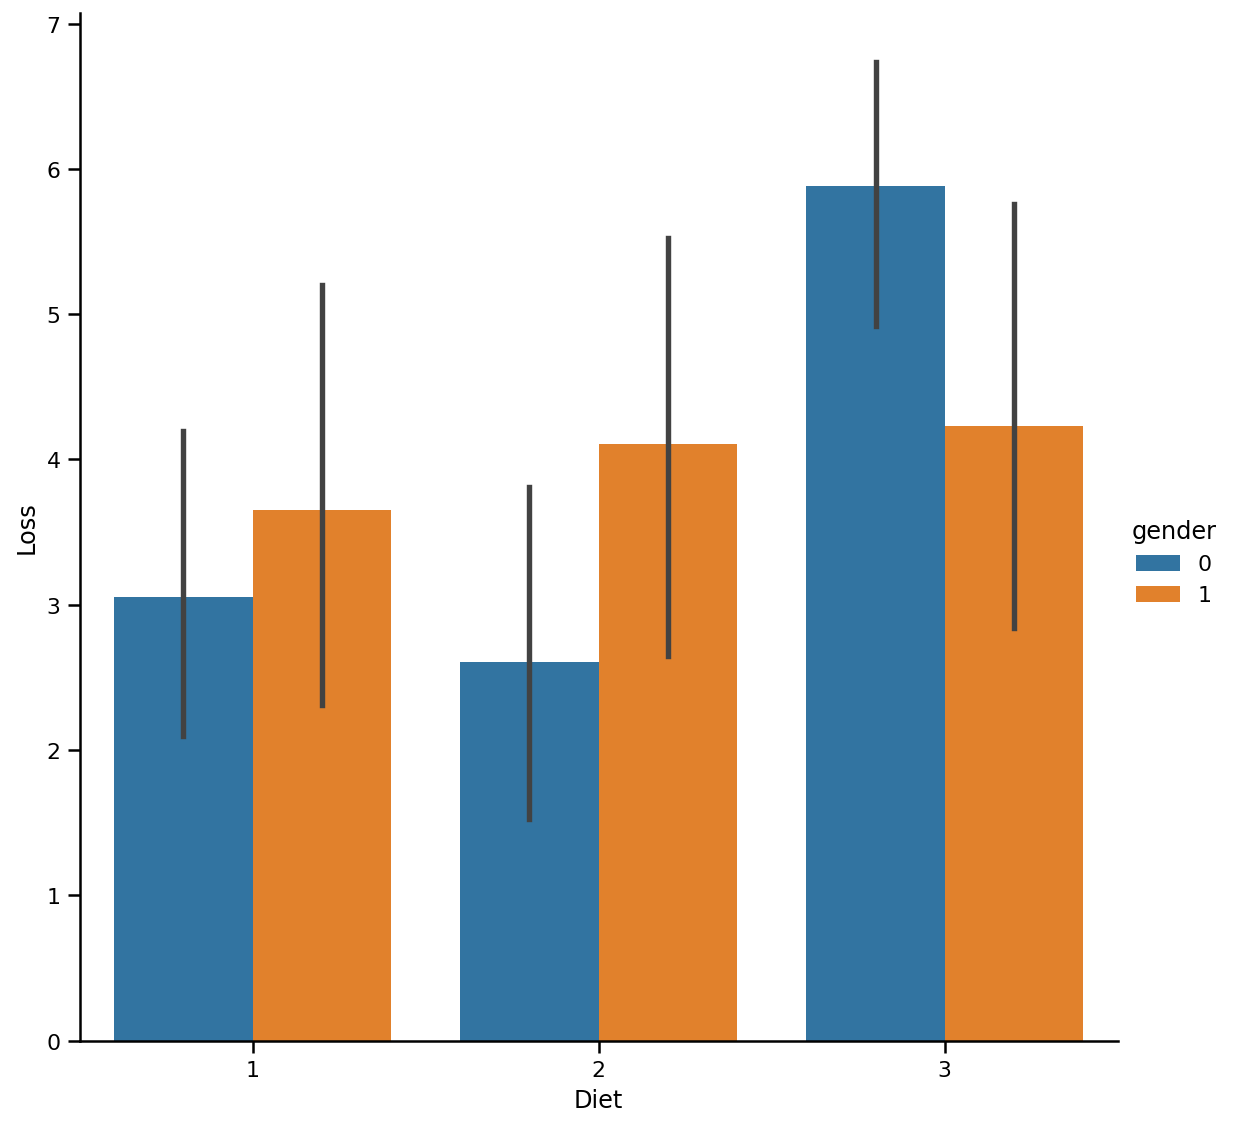

In [65]:
# Use boxplot to synthesize the information
g = sns.catplot(x="Diet", y="Loss", hue="gender",
               data=df, kind="bar", height=8)
plt.show()

In [66]:
# Do an Anova using the statsmodels library
# with the 'loss' as a VD and 'gender' and 'diet' as VI
formula = 'Loss ~ C(Diet) * C(gender)'
model = ols(formula, df).fit()
aov_table = anova_lm(model, typ=2)

# Print the result
print(aov_table)

                       sum_sq    df         F    PR(>F)
C(Diet)             60.417220   2.0  5.619026  0.005456
C(gender)            0.168696   1.0  0.031379  0.859910
C(Diet):C(gender)   33.904068   2.0  3.153204  0.048842
Residual           376.329043  70.0       NaN       NaN


---

The analysis of variance makes the following assumptions about the probability distribution of the responses:

* <b>Independence of observations </b>: The observations are independent of each other.

* <b>Normality</b>: The population from which samples are drawn should be normally distributed.

* <b>Homogeneity of variances</b>: The variance among the groups should be approximately equal</b>.

---

So, are my conclusions valid?

...we need to check the normality of the data.

Let's test the normality of the distribution using a <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html">D’Agostino and Pearson’s</a> test. The <b>null hypothesis</b> is that the <b>data are normally distributed</b>.

In [67]:
# Boolean for selecting the data such as...
# ...gender = 1
is_g1 = df.gender == "1"
# ...diet = 1
is_d1 = df.Diet == 1

# Compute the D'Agostino and Pearson's test
k2, p = stats.normaltest(df.Diet[is_g1 & is_d1])

# Print the result
print(f"k2={k2}, p={p}")

k2=2122.8650702932387, p=0.0


/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


...unfortunately, our sample is too small. Are my conclusions still valid?

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    <br>
    A statistical test have <b>conditions</b> of application relative to the <b>shape of the distributions</b> you wish to compare
    </div>

## I want to test the relation between two (continuous) variables: Regression Analysis

...is probably what you're looking for.

Let's see an example...

---

In [68]:
# Import the data
df = pd.read_csv(os.path.join("data", "rr.csv"))

# Print the top of the file
print(df.head())

     Country  Year        Debt    Growth
0  Australia  1946  190.419080 -3.557951
1  Australia  1947  177.321371  2.459475
2  Australia  1948  148.929811  6.437534
3  Australia  1949  125.828699  6.611994
4  Australia  1950  109.809398  6.920201


Data from <a href="https://pubs.aeaweb.org/doi/pdf/10.1257/aer.100.2.573">Reinhart, C. M., & Rogoff, K. S. (2010). Growth in a Time of Debt. American economic review, 100(2), 573-78.</a>

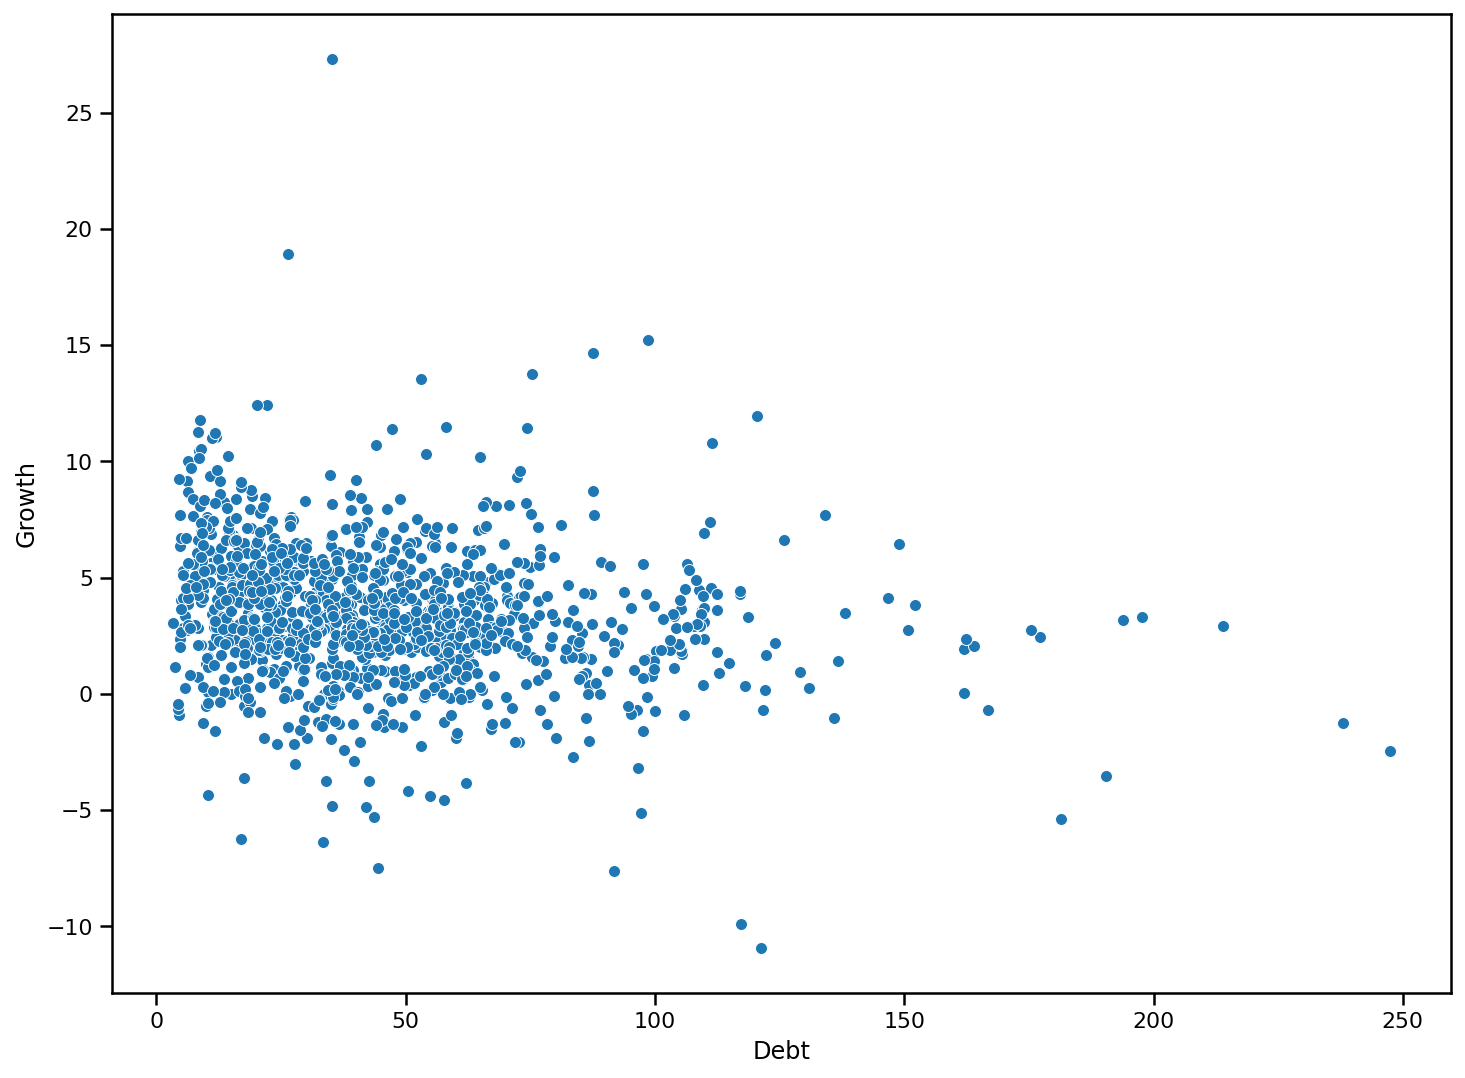

In [69]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 9))

# Plot a scatter plot
sns.scatterplot(x="Debt", y="Growth", ax=ax, data=df)

plt.show()

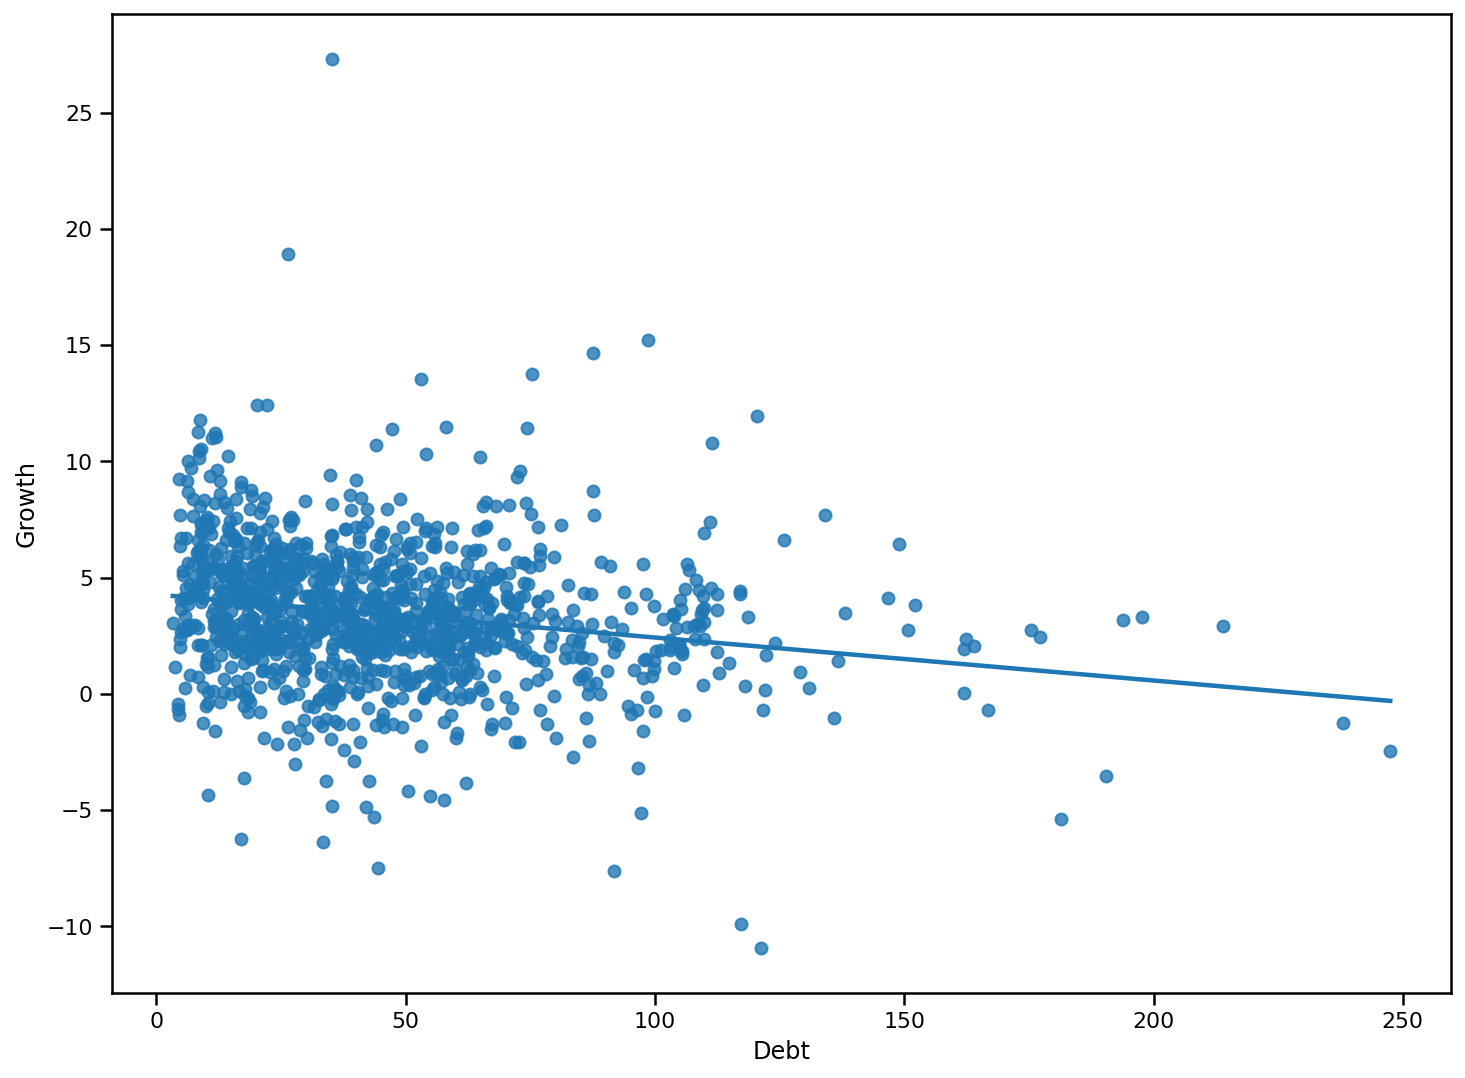

In [70]:
# Create figure and axes
fig, ax =plt.subplots(figsize=(12, 9))

# Plot a scatter plot and a regression line
sns.regplot(x="Debt", y="Growth", data=df, ax=ax, ci=None)

plt.show()


### Compute a Pearson correlation coefficient

The Pearson correlation between $X$ and $Y$ can be expressed as:
$$r_{XY}= \frac {\sum \limits _{i=1}^{n}(x_{i}-{\bar {X}})(y_{i}-{\bar {Y}})}{\sqrt {\sum \limits _{i=1}^{n}(x_{i}-{\bar {X}})^{2}\sum \limits _{i=1}^{n}(y_{i}-{\bar {Y}})^{2}}}$$

where $\overline {X}$ and $\overline {Y}$ are the means of $X$ and $Y$, and $s_{x}$ and $s_{y}$ are the corrected standard deviations of $X$ and $Y$.

Original article:  <a href="https://doi.org/10.1098/rspl.1895.0041">Pearson, Karl (1895). "Notes on regression and inheritance in the case of two parents". Proceedings of the Royal Society of London. 58: 240–242</a>.

---

In [71]:
# Shortcut for our two columns of interest
x, y = df["Debt"], df["Growth"]

# Compute the numerator
r_num = np.sum((x - np.mean(x)) * (y - np.mean(y)))

# Compute the denominator
r_denom = np.sqrt(np.sum((x - np.mean(x))**2))*np.sqrt(np.sum((y - np.mean(y))**2))

# Compute the r-value
r = r_num/r_denom

# Print the result
print("r", r)

r -0.19986576578883175


In [72]:
# Compare with what is obtained using Scipy
r_, p = stats.pearsonr(x, y)
print(f"r={r_}, p={p}")

r=-0.19986576578883178, p=4.723997934448434e-12


---

For computing a p-value, we assume that the coefficient correlation follows a Student's t-distribution. 

We can compute the t-value by using the formula:
$$t=r{\sqrt {\frac {\nu}{1-r^{2}}}}$$
with $\nu = n-2$ the number of degrees of freedom.

Then, we can use the the cumulative distribution function of the t-distribution to compute the p-value.

---

In [73]:
# Get the n
n = len(x)

# Compute the degrees of freedom
dof = n - 2

# Compute the t-value
t = r * np.sqrt(dof/(1 - r**2))

# Compute the p-value
p = 2 * (1 - stats.distributions.t.cdf(np.abs(t), dof))

# Print the result
print("p", p)

p 4.723998969780041e-12


In [74]:
# Compare with what is obtained using Scipy
r_, p = stats.pearsonr(x, y)
print(f"r={r_}, p={p}")

r=-0.19986576578883178, p=4.723997934448434e-12


### Compute a linear regression

$$y = \alpha + \beta x$$ 
which means in this case:
$$\text{Growth} = \alpha + \beta \text{Debt}$$


with:
$$ \alpha ={\bar {y}}-{\beta }\,{\bar {x}}$$

$$ \beta ={\frac {\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}}}$$

In [75]:
# Compute the slope
beta = r_num / np.sum((x - np.mean(x))**2)

# Compute the intercept
alpha = np.mean(y) - beta*np.mean(x)

# Print the results
print(f"alpha={alpha} beta={beta}")

alpha=4.270368134671323 beta=-0.018493267021115034


In [76]:
# Compare with what is obtained using Scipy
res = stats.linregress(df["Debt"], df["Growth"])
alpha = res.intercept
beta = res.slope

# Print the results
print(f"alpha={alpha} beta={beta}")

alpha=4.270368134671323 beta=-0.01849326702111503


---

Don't forget to read the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html">doc</a> for knowing of the conditions of application!

<img src="img/doc_cor.png" width="500">
<img src="img/doc_cor2.png" width="500">

---

So, are my conclusions valid?

...we need to check the normality of the data.

Let's test the normality of the distribution using a <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html">D’Agostino and Pearson’s</a> test. The <b>null hypothesis</b> is that the <b>data are normally distributed</b>.

In [77]:
# Compute the D’Agostino and Pearson’s test for x
k2, p = stats.normaltest(x)

# Print the result
print(f"k2={k2}, p={p}")

k2=396.2673980743888, p=8.94597806691238e-87


In [78]:
# Compute the D’Agostino and Pearson’s test for y
k2, p = stats.normaltest(y)

# Print the result
print(f"k2={k2}, p={p}")

k2=183.83634788701923, p=1.2034949429171269e-40


...what makes sense when looking at the distribution of the data using a histogram (especially for the debt):

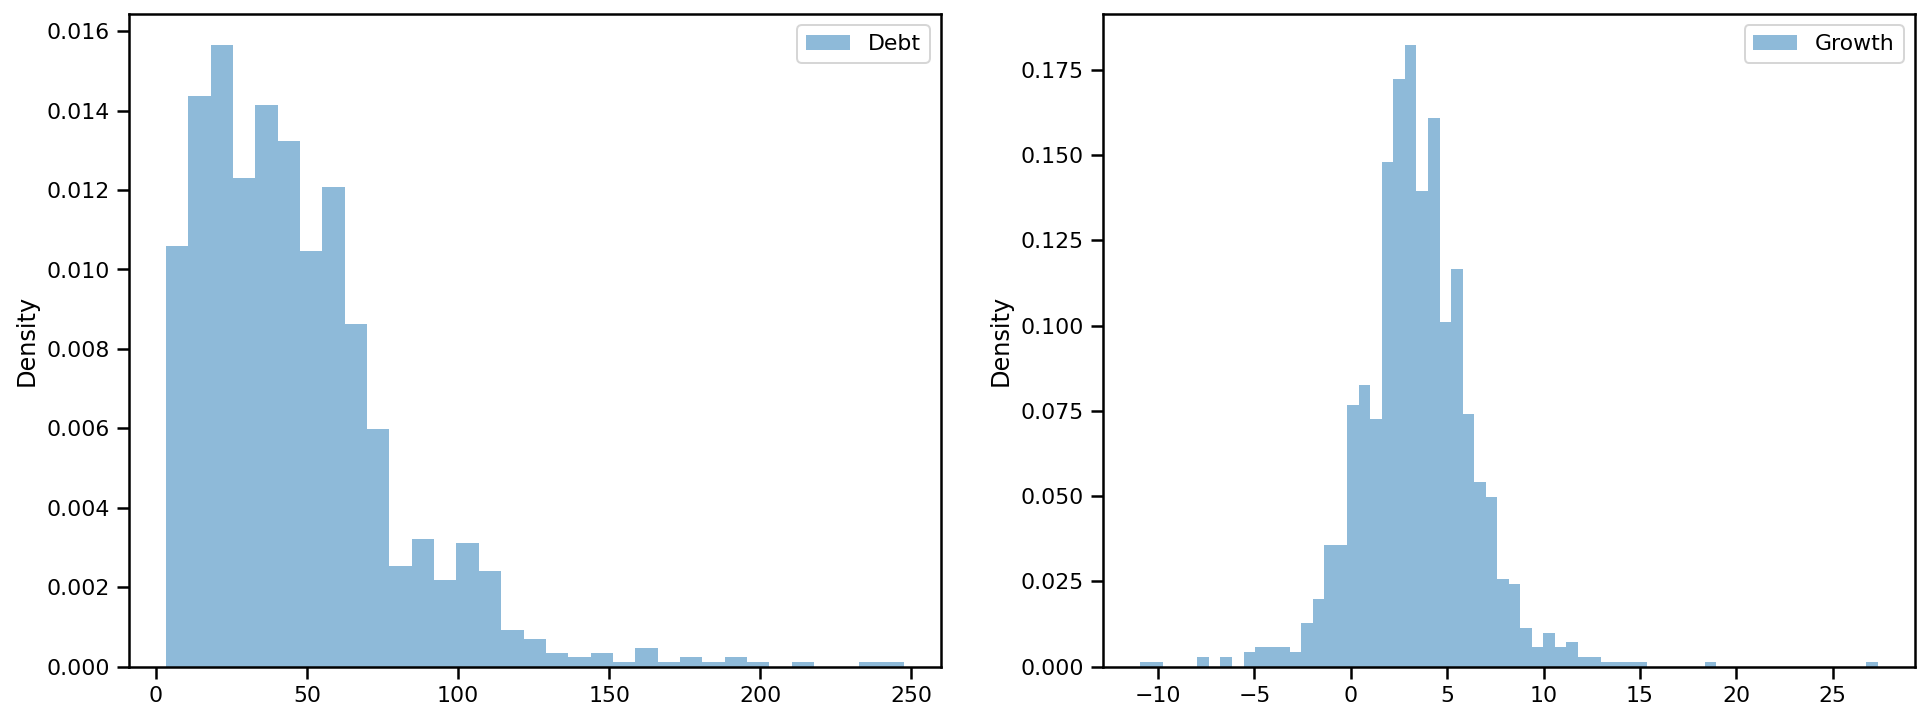

In [79]:
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

# Plot the left histogram
sns.histplot(ax=ax1, data=pd.DataFrame({"Debt": x}),
             stat="density",  linewidth=0, alpha=0.5)

# Plot the right histogram
sns.histplot(ax=ax2, data=pd.DataFrame({"Growth": y}),
             stat="density",  linewidth=0, alpha=0.5)
plt.show()

...so are my conclusions valid?

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    <br>
    A statistical test have <b>conditions</b> of application relative to the <b>shape of the distributions</b> you wish to compare
    </div>

## I have only one group: Confidence Interval

...is probably what you're looking for.

Let's take an example...

---

In [81]:
# Import the data
df = pd.read_csv("data/flights.csv")

# Print the top of the file
df

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01T05:00:00Z
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01T05:00:00Z
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01T05:00:00Z
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01T05:00:00Z
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01T06:00:00Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336771,2013,9,30,NaN,1455,NaN,NaN,1634,NaN,9E,3393,NaN,JFK,DCA,NaN,213,14,55,2013-09-30T14:00:00Z
336772,2013,9,30,NaN,2200,NaN,NaN,2312,NaN,9E,3525,NaN,LGA,SYR,NaN,198,22,0,2013-09-30T22:00:00Z
336773,2013,9,30,NaN,1210,NaN,NaN,1330,NaN,MQ,3461,N535MQ,LGA,BNA,NaN,764,12,10,2013-09-30T12:00:00Z
336774,2013,9,30,NaN,1159,NaN,NaN,1344,NaN,MQ,3572,N511MQ,LGA,CLE,NaN,419,11,59,2013-09-30T11:00:00Z


Data from <a href="https://data.world/bob-wakefield/flights">https://data.world/bob-wakefield/flights</a>

In [82]:
# Clean the data set by removing the nan values
x = df.dropna()["arr_delay"].values
print("x", x)

x [ 11.  20.  33. ... -16.   1. -25.]


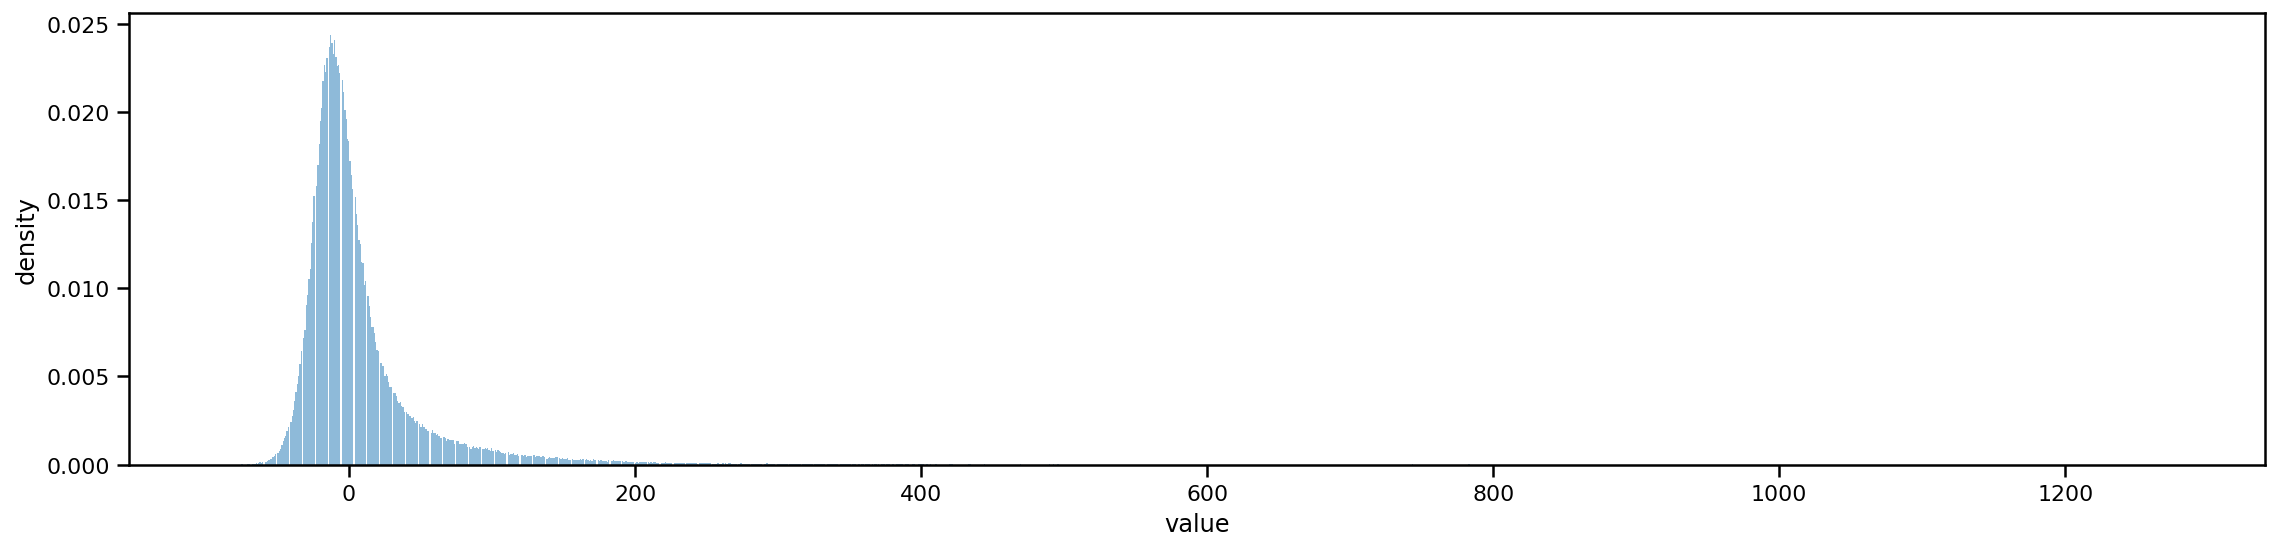

In [83]:
# Create figure and axe
fig, ax = plt.subplots(figsize=(16, 4))

# Plot the histogram
sns.histplot(x="arr_delay", ax=ax, color="C0", linewidth=0, 
             alpha=0.5, stat="density", data=df)

# Set the axis labels
ax.set_ylabel("density")
ax.set_xlabel("value")

plt.tight_layout()
plt.show()

Zooming a little bit...

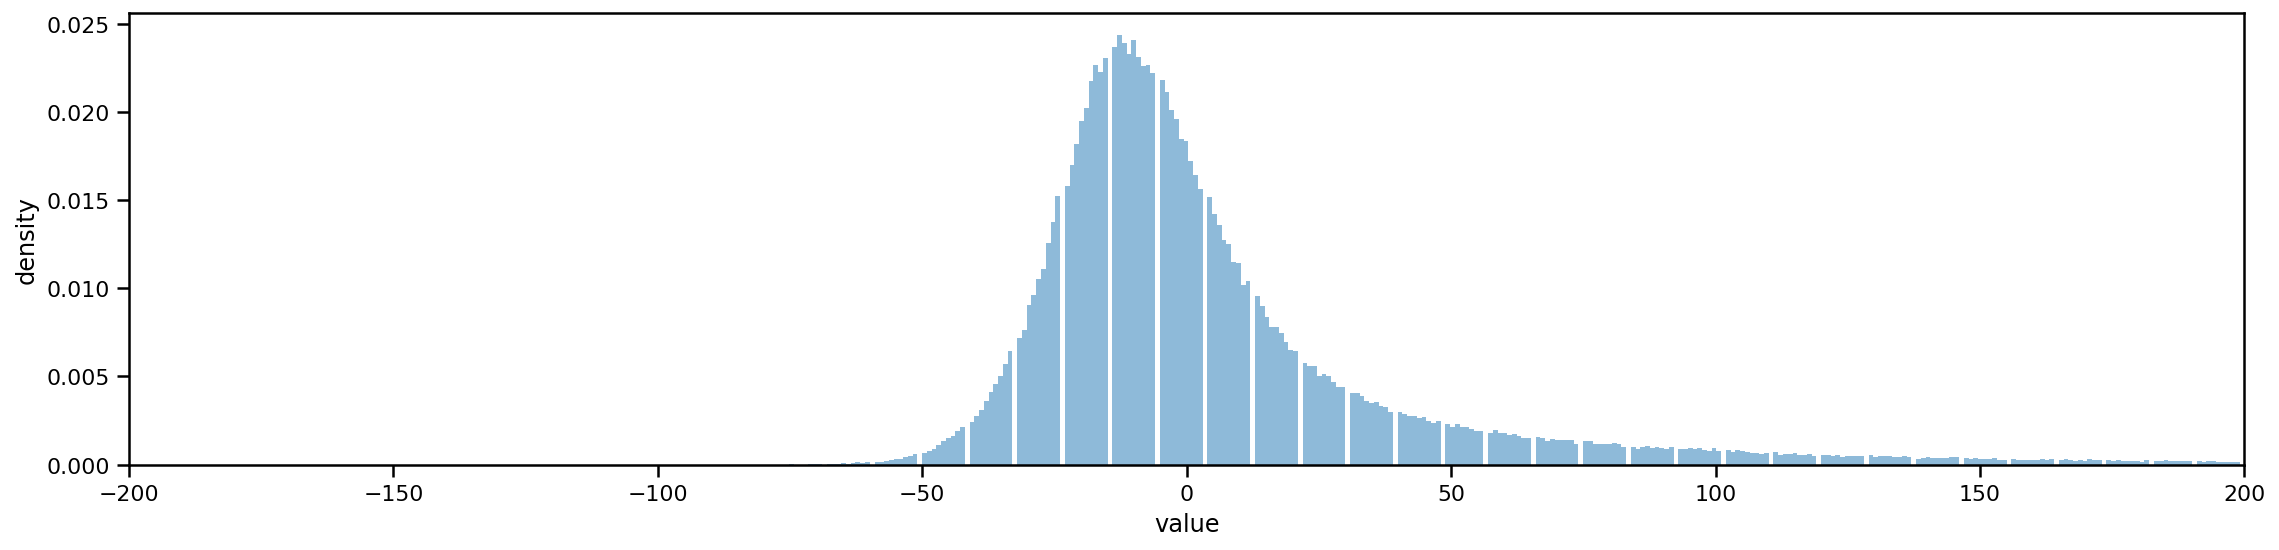

In [84]:
# Create figure and axe
fig, ax = plt.subplots(figsize=(16, 4))

# Plot the histogram
sns.histplot(x="arr_delay", ax=ax, color="C0", linewidth=0, alpha=0.5, stat="density", data=df)

# Set the limits of the x-axis
ax.set_xlim(-200, 200)

# Set the axis labels
ax.set_ylabel("density")
ax.set_xlabel("value")

plt.tight_layout()
plt.show()

---

How to compute a **confidence interval**?

1. Identify the sample mean, $\bar {x}$.


2. Identify whether the population standard deviation is known, $\sigma$, or is unknown and is estimated by the sample standard deviation $s$.

    * If the population standard deviation is known then: 
    $$z^{*}=\Phi ^{-1}\left(1 - \frac{\alpha }{2}\right)$$
    where $\Phi^{-1}$ is the normal inverse CDF.

    * If the population standard deviation is unknown then the Student's t distribution is used as the critical value. This value is dependent on the confidence level (C) for the test and degrees of freedom ($n − 1$). $$t^{*}= F_t^{-1}\left(1 - \frac {\alpha }{2}; \nu \right)$$
    where $F_t^{-1}$ is the inverse of the CDF of $t$ and $\nu$ is the number of degrees of freedom.


3. Plug the found values into the appropriate equations:

    * For a known standard deviation: 
$$\displaystyle \left({\bar {x}}-z^{*}{\sigma  \over {\sqrt {n}}},{\bar {x}}+z^{*}{\sigma  \over {\sqrt {n}}}\right)$$

    * For an unknown standard deviation: 
$$\left({\bar {x}}-t^{*}{s \over {\sqrt {n}}},{\bar {x}}+t^{*}{s \over {\sqrt {n}}}\right)$$

---

Let's assume that we're dealing right now with Z-scores, and let's represent graphically the position of the upper bound...

In [95]:
# Set the threshold
alpha = 0.05

# CDF value at the place of the higher bound
where_to_look = 1 - alpha/2

# Percent point function: inverse of the CDF
z_star = stats.norm.ppf(where_to_look)
print("CDF value at the the higher bound's location", where_to_look)
print(f"z_star {z_star}")

# You may recognize here the magic number of 1.96
print(f"z_star rounded {z_star:.2f}")

CDF value at the the higher bound's location 0.975
z_star 1.959963984540054
z_star rounded 1.96


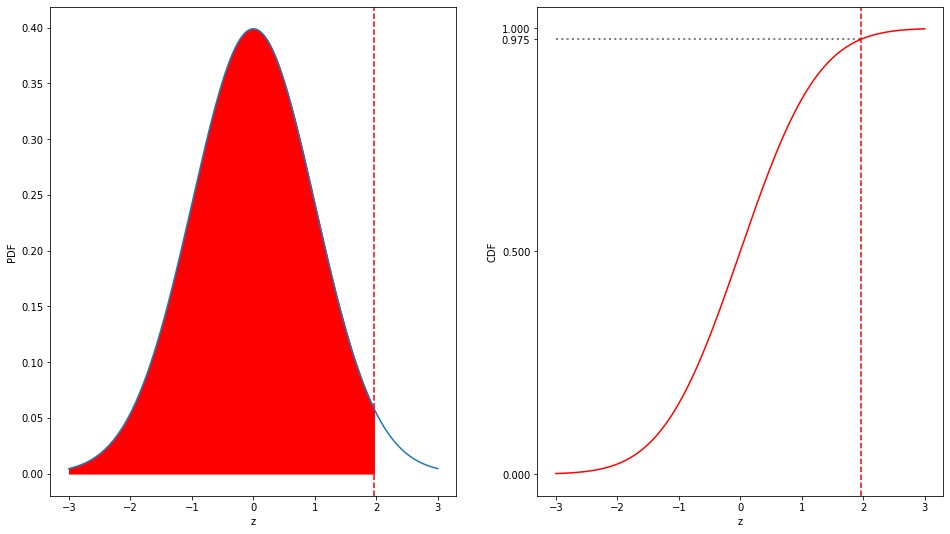

In [195]:
# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 9))

# Set the parameters
mu = 0
sigma = 1

# Set the range of values
z_min, z_max = -3, 3

# Plot the bell curve
z = np.linspace(z_min, z_max, 1000) 
y = stats.norm.pdf(z)
ax1.plot(z, y)

# Plot the position fo the upper bounds
ax1.axvline(z_star, ls='--', color="red")

# Fill the area under the curve
x_f = np.linspace(z_min, z_star, 1000)
y_f = stats.norm.pdf(x_f)
ax1.fill_between(x_f, 0, y_f, color="red")

# Set the axis labels
ax1.set_xlabel("z")
ax1.set_ylabel("PDF")

# Plot the CDF on the right panel
y2 = stats.norm.cdf(z, loc=mu, scale=sigma)
ax2.plot(z, y2, color="red")

# Plot the position of the upper bound
ax2.axvline(z_star, ls='--', color="red")

#. Plot the position of the y-value
ax2.plot((z_min,z_star), (1-alpha/2, 1-alpha/2), color="black", alpha=0.5, lw=2, ls=":")
ax2.set_yticks([0, 0.5, 1-alpha/2, 1])

# Set the axis labels
ax2.set_xlabel("z")
ax2.set_ylabel("CDF")

plt.show()

---

Let's come back to our 'delay of arrival' problem.

Here, as we don't know the standard deviation of our sample, we shall use:

$$\left({\bar {x}}-t^{*}{s \over {\sqrt {n}}},{\bar {x}}+t^{*}{s \over {\sqrt {n}}}\right)$$

But first, we need to check the normality of the data.

Let's test the normality of the distribution using a <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html">D’Agostino and Pearson’s</a> test. The <b>null hypothesis</b> is that the <b>data are normally distributed</b>.

In [196]:
# Compute the D’Agostino and Pearson’s test for our sample
k2, p = stats.normaltest(x)

# Print the result
print(f"k2={k2}, p={p}")

k2=271017.5230787647, p=0.0


The probability to reject the null-hypothesis is close to zero: the data are probability not normally distributed .

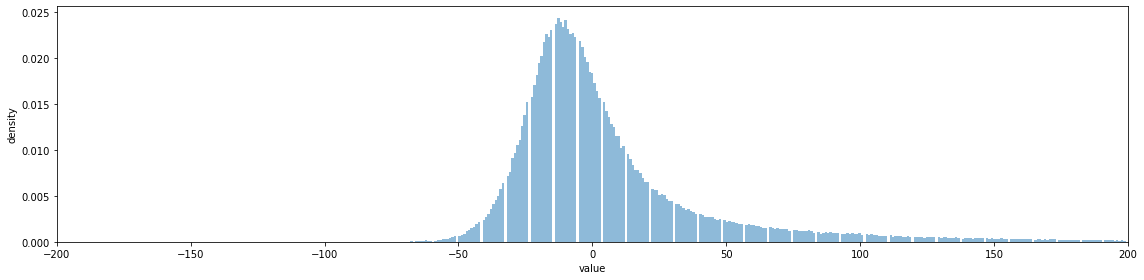

In [197]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(16, 4))

# Plot the histogram
sns.histplot(x="arr_delay", ax=ax, color="C0", linewidth=0, alpha=0.5, stat="density", data=df)

# Set the x-axis limits
ax.set_xlim(-200, 200)

# Set the axis labels
ax.set_ylabel("density")
ax.set_xlabel("value")

plt.tight_layout()
plt.show()

...so what should I do?

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    <br>
    A statistical test have <b>conditions</b> of application relative to the <b>shape of the distributions</b> you wish to test
    </div>

Let's use instead an artificial sample...

In [89]:
# Seed the random number generator
np.random.seed(12345)

# Generate a sample
x = np.random.normal(100, scale=30, size=30)

# Print a few values
print("x", x)

x [ 93.85877022 114.36830014  84.41683855 ... 115.71316204 100.02820833
 140.31429381]


In [90]:
# Compute the D’Agostino and Pearson’s test for this new sample
k2, p = stats.normaltest(x)

# Print the result
print(f"k2={k2}, p={p}")

k2=2.4503721339830875, p=0.29370304679675713


The probability to reject the null-hypothesis by error is high: the data are probability normally distributed (and we know that they actually are since we artificially produced them).

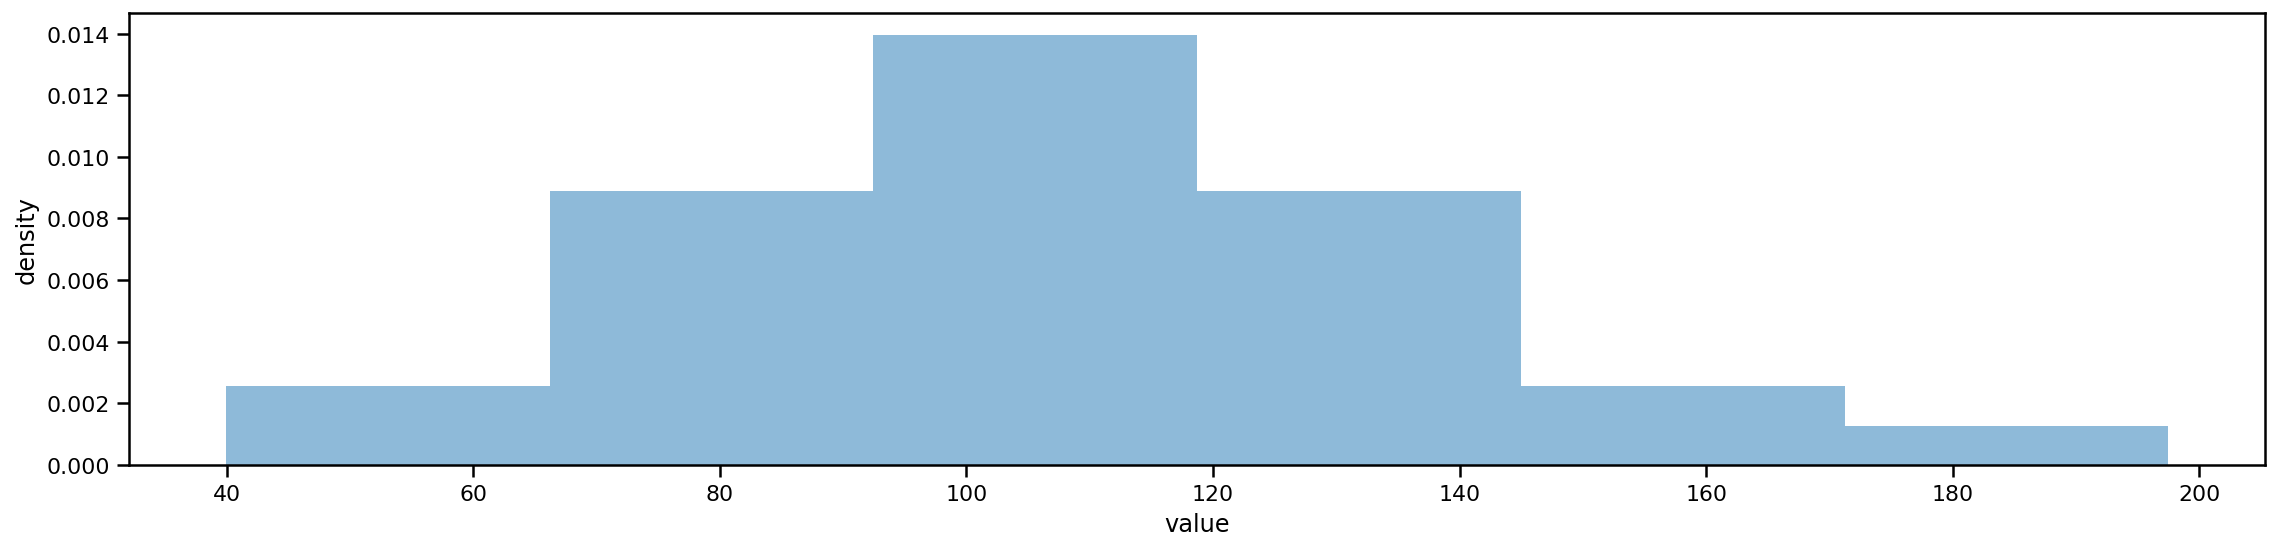

In [91]:
# Create the figure
fig, ax = plt.subplots(figsize=(16, 4))

# Plot the histogram
sns.histplot(x, ax=ax, color="C0", linewidth=0, alpha=0.5, stat="density")

# Set the axis labels
ax.set_ylabel("density")
ax.set_xlabel("value")

plt.tight_layout()
plt.show()

In [92]:
# Set the threshold
alpha = 0.05

# Get the sample size
n = len(x)

# Compute the mean
m = np.mean(x)

# Compute the standard error
se = stats.sem(x)

# Compute the CDF value at the upper bound
cdf_value_upper_bound = 1 - alpha / 2.

# Compute the number of degrees of freedom
dof = n-1

# Compute the size of half of the confidence interval
c = se * stats.t.ppf(cdf_value_upper_bound, dof)  # Percent point function: inverse of the CDF

# Compute the confidence interval
ic = m-c, m+c

# Print the result
print("IC", ic)

IC (98.25481965822752, 122.03055773327455)


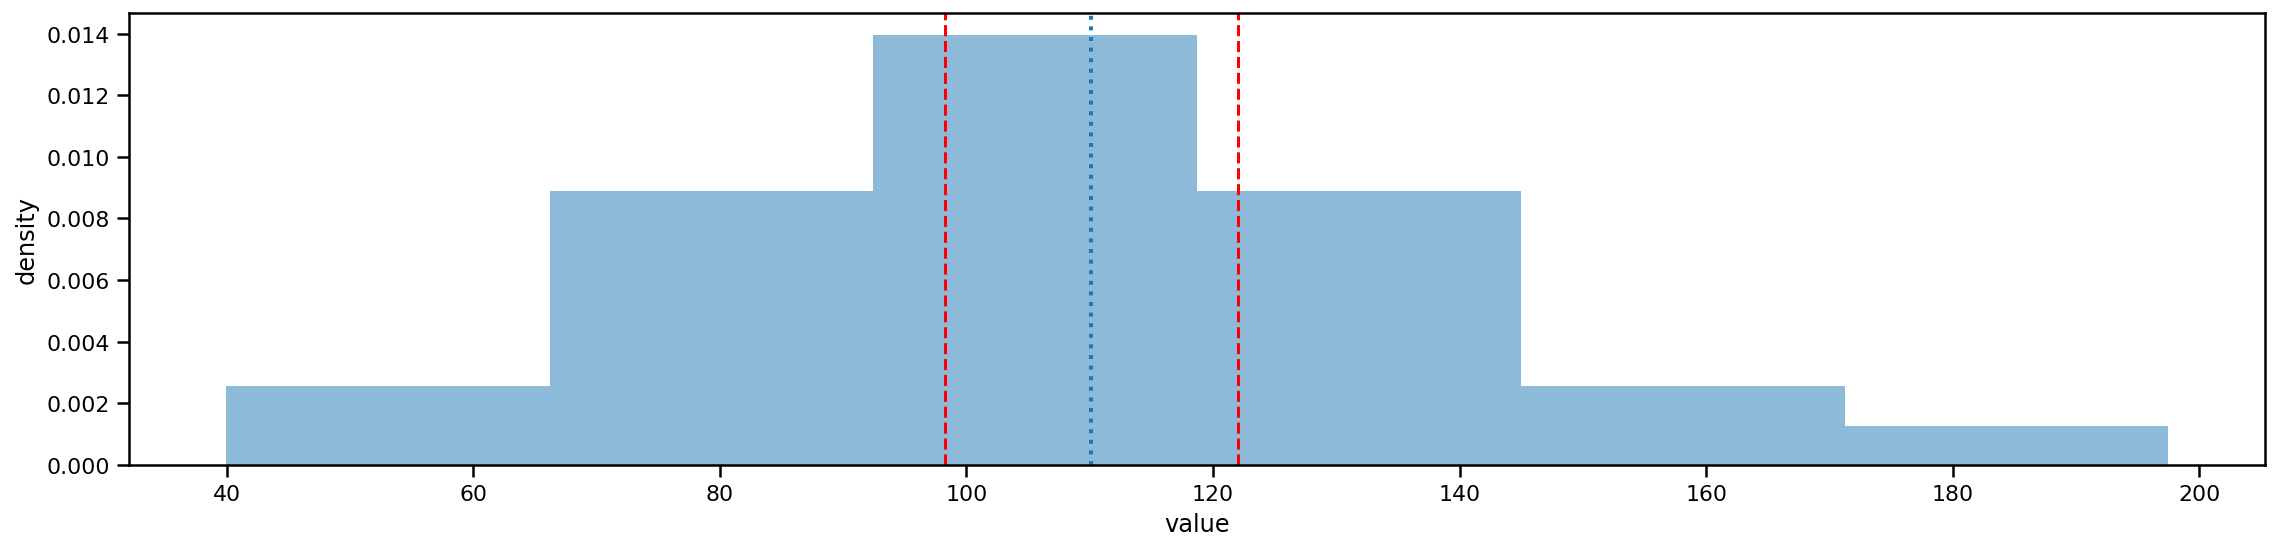

In [93]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(16, 4))

# Plot the histogram
sns.histplot(x, ax=ax, color="C0", linewidth=0, alpha=0.5, stat="density")

# Set the axis labels
ax.set_ylabel("density")
ax.set_xlabel("value")

# Plot the vertical lines
ax.axvline(ic[0], ls="--", color="red")
ax.axvline(ic[1], ls="--", color="red")
ax.axvline(m, color="C0", lw=2, ls=':')

plt.tight_layout()
plt.show()

# External validity: The todo-NOT list

*1* Do **not** think that a **significant** result means that you're sure that there is a **causal** relationship (remember the <a href="http://www.tylervigen.com/spurious-correlations">spurious correlations</a>)

<img src="img/happy.png" width="500">

*2* Do **not multiply** the post hoc **analysis** until you get something **significant**

<img src="img/Eureka-1.jpg" width="300">

*3* Do not think that a non-significant result means that there is no effect: "**Absence of evidence is not evidence of absence**"

<img src="img/comics_sign.jpeg" width="500">

# Additional material

### Compare the shape of a t-distribution and a normal distribution<a class="tocSkip"></a>

In [2]:
fig, ax = plt.subplots(figsize=(16, 9))

mu = 0
sig = 1

x = np.linspace(-12, 12, 1000)
y1 = stats.norm.pdf(x, loc=mu, scale=sig)
ax.plot(x, y1, label="normal dist", ls="--")

for df in (1, 5, 20):
    y2 = stats.t.pdf(x, loc=mu, scale=sig, df=df)
    ax.plot(x, y2, label=f"t-dist DoF={df}")

ax.set_ylabel('Density')

plt.legend()
plt.show()

NameError: name 'plt' is not defined

### Note on the degrees of freedom<a class="tocSkip"></a>


What are degrees of freedom?

>We know that the the sum of deviations around any mean must equal zero. 

>Therefore for any variable, if the mean is known and the first $n-1$ observations are known, then the $n^{th}$ observation must be the value that causes the sum of all the deviations around the mean to equal zero. 

>$n-1$ is called the degrees of freedom because the first $n-1$ observations have the <b>freedom</b> to be any value they want to be, but the $n^{th}$ value has no freedom. It must be whatever value that forces the sum of deviations around the mean to equal zero. 

From a discussion on <a href="https://www.khanacademy.org/math/statistics-probability/confidence-intervals-one-sample/old-confidence-interval-videos/v/t-statistic-confidence-interval">Khan Academy</a>.

### Another way to run an ANOVA<a class="tocSkip"></a>

In [204]:
# Compute a regression analyis using 'statsmodels' library
# which is more 'R' like and more verbose
df = pd.read_csv(os.path.join("data", "rr.csv"))

formula = "Growth ~ Debt"
model =  ols(formula, df).fit()

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 Growth   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     48.81
Date:                Tue, 15 Sep 2020   Prob (F-statistic):           4.72e-12
Time:                        13:10:42   Log-Likelihood:                -2930.9
No. Observations:                1175   AIC:                             5866.
Df Residuals:                    1173   BIC:                             5876.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2704      0.150     28.558      0.0